In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
#     hh = generate_h(n_beta, t_len, normalize)
#     bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[:3], n_beta, t_len, normalize=True)

Dimension - time and Cm:  (15000, 2)
Dimension - x:  (15000, 1)
Dimension - y:  (15000, 1)


In [19]:
x -=10

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221227_012Flaps_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221227unsteadyPrediction_MLP_012Flaps_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 1/10 [==>...........................] - ETA: 16s - loss: 0.1945 - rmse: 0.4409
Epoch 1: val_loss improved from inf to 0.10290, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 2s 29ms/step - loss: 0.1374 - rmse: 0.3705 - val_loss: 0.1029 - val_rmse: 0.3206 - lr: 1.0000e-04
Epoch 2/10000
 1/10 [==>...........................] - ETA: 0s - loss: 0.0923 - rmse: 0.3037
Epoch 2: val_loss improved from 0.10290 to 0.10182, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 13ms/step - loss: 0.0975 - rmse: 0.3120 - val_loss: 0.1018 - val_rmse: 0.3189 - lr: 1.0000e-04
Epoch 3/10000
 1/10 [==>...........................] - ETA: 0s - loss: 0.0961 - rmse: 0.3099
Epoch 3: val_los

10/10 [==============================] - 0s 15ms/step - loss: 0.0659 - rmse: 0.2565 - val_loss: 0.0678 - val_rmse: 0.2601 - lr: 1.0000e-04
Epoch 20/10000
10/10 [==============================] - ETA: 0s - loss: 0.0648 - rmse: 0.2543
Epoch 20: val_loss improved from 0.06776 to 0.06736, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 15ms/step - loss: 0.0648 - rmse: 0.2543 - val_loss: 0.0674 - val_rmse: 0.2593 - lr: 1.0000e-04
Epoch 21/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0645 - rmse: 0.2538
Epoch 21: val_loss improved from 0.06736 to 0.06700, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0645 - rmse: 0.2537 - val_loss: 0.0670

10/10 [==============================] - 0s 16ms/step - loss: 0.0608 - rmse: 0.2464 - val_loss: 0.0624 - val_rmse: 0.2495 - lr: 1.0000e-04
Epoch 39/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0600 - rmse: 0.2447
Epoch 39: val_loss improved from 0.06237 to 0.06203, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0603 - rmse: 0.2453 - val_loss: 0.0620 - val_rmse: 0.2489 - lr: 1.0000e-04
Epoch 40/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0595 - rmse: 0.2438
Epoch 40: val_loss improved from 0.06203 to 0.06163, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0600 - rmse: 0.2447 - val_loss: 0.0616

Epoch 59/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0563 - rmse: 0.2371
Epoch 59: val_loss improved from 0.05709 to 0.05689, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0564 - rmse: 0.2372 - val_loss: 0.0569 - val_rmse: 0.2383 - lr: 1.0000e-04
Epoch 60/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0550 - rmse: 0.2344
Epoch 60: val_loss improved from 0.05689 to 0.05678, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0550 - rmse: 0.2342 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 61/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0549 - rmse: 0.2340
Epoch 61

10/10 [==============================] - 0s 11ms/step - loss: 0.0537 - rmse: 0.2315 - val_loss: 0.0553 - val_rmse: 0.2350 - lr: 1.0000e-04
Epoch 81/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0544 - rmse: 0.2331
Epoch 81: val_loss did not improve from 0.05529
10/10 [==============================] - 0s 11ms/step - loss: 0.0545 - rmse: 0.2333 - val_loss: 0.0554 - val_rmse: 0.2351 - lr: 1.0000e-04
Epoch 82/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0539 - rmse: 0.2320
Epoch 82: val_loss improved from 0.05529 to 0.05526, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 28ms/step - loss: 0.0532 - rmse: 0.2304 - val_loss: 0.0553 - val_rmse: 0.2349 - lr: 1.0000e-04
Epoch 83/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0551 - rmse: 0.2344
Epoch 83: val_loss did not improve fr

Epoch 126/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0534 - rmse: 0.2308
Epoch 126: val_loss did not improve from 0.05450
10/10 [==============================] - 0s 11ms/step - loss: 0.0532 - rmse: 0.2305 - val_loss: 0.0546 - val_rmse: 0.2335 - lr: 1.0000e-04
Epoch 127/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0532 - rmse: 0.2305
Epoch 127: val_loss did not improve from 0.05450
10/10 [==============================] - 0s 11ms/step - loss: 0.0531 - rmse: 0.2302 - val_loss: 0.0547 - val_rmse: 0.2337 - lr: 1.0000e-04
Epoch 128/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0544 - rmse: 0.2330
Epoch 128: val_loss did not improve from 0.05450
10/10 [==============================] - 0s 11ms/step - loss: 0.0538 - rmse: 0.2318 - val_loss: 0.0547 - val_rmse: 0.2336 - lr: 1.0000e-04
Epoch 129/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0530 - rmse: 0.2300
Epoch 129: val_loss improved from 0.05450 to 0.05436, sa

Epoch 150/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0527 - rmse: 0.2295
Epoch 150: val_loss improved from 0.05394 to 0.05380, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0531 - rmse: 0.2303 - val_loss: 0.0538 - val_rmse: 0.2318 - lr: 1.0000e-04
Epoch 151/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0526 - rmse: 0.2292
Epoch 151: val_loss did not improve from 0.05380
10/10 [==============================] - 0s 11ms/step - loss: 0.0526 - rmse: 0.2291 - val_loss: 0.0545 - val_rmse: 0.2332 - lr: 1.0000e-04
Epoch 152/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0527 - rmse: 0.2293
Epoch 152: val_loss did not improve from 0.05380
10/10 [==============================] - 0s 11ms/step - loss: 0.0532 - rmse: 0.2305 - val_loss: 0.0541 - val_rmse: 0.2324 

Epoch 172/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0535 - rmse: 0.2311
Epoch 172: val_loss improved from 0.05307 to 0.05304, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0528 - rmse: 0.2295 - val_loss: 0.0530 - val_rmse: 0.2301 - lr: 1.0000e-04
Epoch 173/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0513 - rmse: 0.2264
Epoch 173: val_loss did not improve from 0.05304
10/10 [==============================] - 0s 11ms/step - loss: 0.0521 - rmse: 0.2282 - val_loss: 0.0531 - val_rmse: 0.2302 - lr: 1.0000e-04
Epoch 174/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0512 - rmse: 0.2261
Epoch 174: val_loss improved from 0.05304 to 0.05303, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1

10/10 [==============================] - 0s 17ms/step - loss: 0.0510 - rmse: 0.2257 - val_loss: 0.0519 - val_rmse: 0.2277 - lr: 1.0000e-04
Epoch 194/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0497 - rmse: 0.2227
Epoch 194: val_loss did not improve from 0.05194
10/10 [==============================] - 0s 11ms/step - loss: 0.0500 - rmse: 0.2233 - val_loss: 0.0522 - val_rmse: 0.2282 - lr: 1.0000e-04
Epoch 195/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0512 - rmse: 0.2261
Epoch 195: val_loss improved from 0.05194 to 0.05192, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0513 - rmse: 0.2263 - val_loss: 0.0519 - val_rmse: 0.2277 - lr: 1.0000e-04
Epoch 196/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0507 - rmse: 0.2249
Epoch 196: val_loss improved fro

Epoch 216/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0489 - rmse: 0.2211
Epoch 216: val_loss improved from 0.05063 to 0.05038, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0488 - rmse: 0.2208 - val_loss: 0.0504 - val_rmse: 0.2243 - lr: 1.0000e-04
Epoch 217/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0504 - rmse: 0.2244
Epoch 217: val_loss improved from 0.05038 to 0.05023, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0502 - rmse: 0.2238 - val_loss: 0.0502 - val_rmse: 0.2239 - lr: 1.0000e-04
Epoch 218/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0487 - rmse: 0.2206
Epo

10/10 [==============================] - 0s 17ms/step - loss: 0.0479 - rmse: 0.2186 - val_loss: 0.0481 - val_rmse: 0.2191 - lr: 1.0000e-04
Epoch 238/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0475 - rmse: 0.2177
Epoch 238: val_loss improved from 0.04807 to 0.04788, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0477 - rmse: 0.2183 - val_loss: 0.0479 - val_rmse: 0.2186 - lr: 1.0000e-04
Epoch 239/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0469 - rmse: 0.2165
Epoch 239: val_loss did not improve from 0.04788
10/10 [==============================] - 0s 11ms/step - loss: 0.0468 - rmse: 0.2162 - val_loss: 0.0479 - val_rmse: 0.2188 - lr: 1.0000e-04
Epoch 240/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0475 - rmse: 0.2177
Epoch 240: val_loss improved fro

Epoch 259/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0426 - rmse: 0.2063
Epoch 259: val_loss improved from 0.04526 to 0.04519, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0436 - rmse: 0.2087 - val_loss: 0.0452 - val_rmse: 0.2124 - lr: 1.0000e-04
Epoch 260/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0464 - rmse: 0.2151
Epoch 260: val_loss improved from 0.04519 to 0.04479, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0458 - rmse: 0.2139 - val_loss: 0.0448 - val_rmse: 0.2114 - lr: 1.0000e-04
Epoch 261/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0427 - rmse: 0.2065
Epo

10/10 [==============================] - 0s 17ms/step - loss: 0.0418 - rmse: 0.2044 - val_loss: 0.0421 - val_rmse: 0.2051 - lr: 1.0000e-04
Epoch 280/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0417 - rmse: 0.2039
Epoch 280: val_loss improved from 0.04213 to 0.04213, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0417 - rmse: 0.2041 - val_loss: 0.0421 - val_rmse: 0.2051 - lr: 1.0000e-04
Epoch 281/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0419 - rmse: 0.2046
Epoch 281: val_loss improved from 0.04213 to 0.04186, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0417 - rmse: 0.2041 - val_loss: 0.

Epoch 302/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0404 - rmse: 0.2008
Epoch 302: val_loss improved from 0.03990 to 0.03985, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0403 - rmse: 0.2005 - val_loss: 0.0399 - val_rmse: 0.1994 - lr: 1.0000e-04
Epoch 303/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0388 - rmse: 0.1967
Epoch 303: val_loss did not improve from 0.03985
10/10 [==============================] - 0s 11ms/step - loss: 0.0395 - rmse: 0.1985 - val_loss: 0.0399 - val_rmse: 0.1995 - lr: 1.0000e-04
Epoch 304/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0381 - rmse: 0.1951
Epoch 304: val_loss improved from 0.03985 to 0.03970, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1

10/10 [==============================] - 0s 11ms/step - loss: 0.0375 - rmse: 0.1935 - val_loss: 0.0382 - val_rmse: 0.1953 - lr: 1.0000e-04
Epoch 325/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0384 - rmse: 0.1958
Epoch 325: val_loss did not improve from 0.03813
10/10 [==============================] - 0s 11ms/step - loss: 0.0381 - rmse: 0.1951 - val_loss: 0.0382 - val_rmse: 0.1952 - lr: 1.0000e-04
Epoch 326/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0383 - rmse: 0.1955
Epoch 326: val_loss did not improve from 0.03813
10/10 [==============================] - 0s 11ms/step - loss: 0.0384 - rmse: 0.1957 - val_loss: 0.0382 - val_rmse: 0.1952 - lr: 1.0000e-04
Epoch 327/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0382 - rmse: 0.1952
Epoch 327: val_loss improved from 0.03813 to 0.03789, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState

10/10 [==============================] - 0s 16ms/step - loss: 0.0365 - rmse: 0.1910 - val_loss: 0.0360 - val_rmse: 0.1896 - lr: 1.0000e-04
Epoch 375/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0370 - rmse: 0.1921
Epoch 375: val_loss did not improve from 0.03602
10/10 [==============================] - 0s 11ms/step - loss: 0.0369 - rmse: 0.1918 - val_loss: 0.0371 - val_rmse: 0.1925 - lr: 1.0000e-04
Epoch 376/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0354 - rmse: 0.1881
Epoch 376: val_loss did not improve from 0.03602
10/10 [==============================] - 0s 11ms/step - loss: 0.0354 - rmse: 0.1881 - val_loss: 0.0363 - val_rmse: 0.1902 - lr: 1.0000e-04
Epoch 377/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0358 - rmse: 0.1891
Epoch 377: val_loss did not improve from 0.03602
10/10 [==============================] - 0s 11ms/step - loss: 0.0361 - rmse: 0.1897 - val_loss: 0.0360 - val_rmse: 0.1896 - lr: 1.0000e-04
Epoch 378/10

10/10 [==============================] - 0s 17ms/step - loss: 0.0354 - rmse: 0.1879 - val_loss: 0.0351 - val_rmse: 0.1872 - lr: 1.0000e-04
Epoch 399/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0344 - rmse: 0.1852
Epoch 399: val_loss did not improve from 0.03510
10/10 [==============================] - 0s 11ms/step - loss: 0.0342 - rmse: 0.1847 - val_loss: 0.0352 - val_rmse: 0.1873 - lr: 1.0000e-04
Epoch 400/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0352 - rmse: 0.1874
Epoch 400: val_loss did not improve from 0.03510
10/10 [==============================] - 0s 11ms/step - loss: 0.0350 - rmse: 0.1868 - val_loss: 0.0352 - val_rmse: 0.1875 - lr: 1.0000e-04
Epoch 401/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0359 - rmse: 0.1893
Epoch 401: val_loss did not improve from 0.03510
10/10 [==============================] - 0s 10ms/step - loss: 0.0352 - rmse: 0.1875 - val_loss: 0.0352 - val_rmse: 0.1874 - lr: 1.0000e-04
Epoch 402/10

Epoch 450/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0338 - rmse: 0.1838
Epoch 450: val_loss did not improve from 0.03324
10/10 [==============================] - 0s 11ms/step - loss: 0.0339 - rmse: 0.1838 - val_loss: 0.0346 - val_rmse: 0.1859 - lr: 1.0000e-04
Epoch 451/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0332 - rmse: 0.1820
Epoch 451: val_loss improved from 0.03324 to 0.03311, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0334 - rmse: 0.1825 - val_loss: 0.0331 - val_rmse: 0.1818 - lr: 1.0000e-04
Epoch 452/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0329 - rmse: 0.1812
Epoch 452: val_loss did not improve from 0.03311
10/10 [==============================] - 0s 11ms/step - loss: 0.0331 - rmse: 0.1817 - val_loss: 0.0334 - val_rmse: 0.1826 

Epoch 475/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0328 - rmse: 0.1808
Epoch 475: val_loss did not improve from 0.03243
10/10 [==============================] - 0s 11ms/step - loss: 0.0327 - rmse: 0.1805 - val_loss: 0.0334 - val_rmse: 0.1824 - lr: 1.0000e-04
Epoch 476/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0333 - rmse: 0.1822
Epoch 476: val_loss did not improve from 0.03243
10/10 [==============================] - 0s 11ms/step - loss: 0.0331 - rmse: 0.1819 - val_loss: 0.0327 - val_rmse: 0.1806 - lr: 1.0000e-04
Epoch 477/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0323 - rmse: 0.1796
Epoch 477: val_loss improved from 0.03243 to 0.03242, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0322 - rmse: 0.1794 - val_loss: 0.0324 - val_rmse: 0.1799 

Epoch 524/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0292 - rmse: 0.1706
Epoch 524: val_loss did not improve from 0.03028
10/10 [==============================] - 0s 11ms/step - loss: 0.0293 - rmse: 0.1709 - val_loss: 0.0303 - val_rmse: 0.1739 - lr: 1.0000e-04
Epoch 525/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0306 - rmse: 0.1747
Epoch 525: val_loss improved from 0.03028 to 0.03007, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0303 - rmse: 0.1740 - val_loss: 0.0301 - val_rmse: 0.1732 - lr: 1.0000e-04
Epoch 526/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0301 - rmse: 0.1734
Epoch 526: val_loss did not improve from 0.03007
10/10 [==============================] - 0s 11ms/step - loss: 0.0300 - rmse: 0.1729 - val_loss: 0.0301 - val_rmse: 0.1734 

 8/10 [=======================>......] - ETA: 0s - loss: 0.0291 - rmse: 0.1705
Epoch 547: val_loss did not improve from 0.02907
10/10 [==============================] - 0s 11ms/step - loss: 0.0287 - rmse: 0.1694 - val_loss: 0.0294 - val_rmse: 0.1713 - lr: 1.0000e-04
Epoch 548/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0300 - rmse: 0.1729
Epoch 548: val_loss did not improve from 0.02907
10/10 [==============================] - 0s 11ms/step - loss: 0.0301 - rmse: 0.1733 - val_loss: 0.0308 - val_rmse: 0.1754 - lr: 1.0000e-04
Epoch 549/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0295 - rmse: 0.1714
Epoch 549: val_loss did not improve from 0.02907
10/10 [==============================] - 0s 11ms/step - loss: 0.0296 - rmse: 0.1719 - val_loss: 0.0293 - val_rmse: 0.1709 - lr: 1.0000e-04
Epoch 550/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0288 - rmse: 0.1695
Epoch 550: val_loss did not improve from 0.02907
10/10 [================

10/10 [==============================] - 0s 11ms/step - loss: 0.0285 - rmse: 0.1685 - val_loss: 0.0286 - val_rmse: 0.1690 - lr: 1.0000e-04
Epoch 573/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0284 - rmse: 0.1683
Epoch 573: val_loss improved from 0.02827 to 0.02797, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0284 - rmse: 0.1683 - val_loss: 0.0280 - val_rmse: 0.1671 - lr: 1.0000e-04
Epoch 574/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0284 - rmse: 0.1682
Epoch 574: val_loss improved from 0.02797 to 0.02791, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 21ms/step - loss: 0.0282 - rmse: 0.1678 - val_loss: 0.

 8/10 [=======================>......] - ETA: 0s - loss: 0.0257 - rmse: 0.1601
Epoch 621: val_loss improved from 0.02592 to 0.02562, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0260 - rmse: 0.1611 - val_loss: 0.0256 - val_rmse: 0.1599 - lr: 1.0000e-04
Epoch 622/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0268 - rmse: 0.1635
Epoch 622: val_loss did not improve from 0.02562
10/10 [==============================] - 0s 11ms/step - loss: 0.0265 - rmse: 0.1625 - val_loss: 0.0269 - val_rmse: 0.1639 - lr: 1.0000e-04
Epoch 623/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0257 - rmse: 0.1603
Epoch 623: val_loss did not improve from 0.02562
10/10 [==============================] - 0s 11ms/step - loss: 0.0262 - rmse: 0.1618 - val_loss: 0.0258 - val_rmse: 0.1606 - lr: 1.0000e-04

Epoch 646/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0253 - rmse: 0.1590
Epoch 646: val_loss did not improve from 0.02435
10/10 [==============================] - 0s 12ms/step - loss: 0.0254 - rmse: 0.1591 - val_loss: 0.0245 - val_rmse: 0.1563 - lr: 1.0000e-04
Epoch 647/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0244 - rmse: 0.1561
Epoch 647: val_loss did not improve from 0.02435
10/10 [==============================] - 0s 12ms/step - loss: 0.0243 - rmse: 0.1558 - val_loss: 0.0244 - val_rmse: 0.1560 - lr: 1.0000e-04
Epoch 648/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0250 - rmse: 0.1578
Epoch 648: val_loss did not improve from 0.02435
10/10 [==============================] - 0s 12ms/step - loss: 0.0250 - rmse: 0.1579 - val_loss: 0.0246 - val_rmse: 0.1567 - lr: 1.0000e-04
Epoch 649/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0241 - rmse: 0.1550
Epoch 649: val_loss improved from 0.02435 to 0.02412, sa

10/10 [==============================] - 0s 12ms/step - loss: 0.0234 - rmse: 0.1527 - val_loss: 0.0241 - val_rmse: 0.1550 - lr: 1.0000e-04
Epoch 672/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0234 - rmse: 0.1529
Epoch 672: val_loss improved from 0.02332 to 0.02287, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 20ms/step - loss: 0.0232 - rmse: 0.1522 - val_loss: 0.0229 - val_rmse: 0.1510 - lr: 1.0000e-04
Epoch 673/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0231 - rmse: 0.1519
Epoch 673: val_loss did not improve from 0.02287
10/10 [==============================] - 0s 12ms/step - loss: 0.0230 - rmse: 0.1513 - val_loss: 0.0231 - val_rmse: 0.1518 - lr: 1.0000e-04
Epoch 674/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0228 - rmse: 0.1507
Epoch 674: val_loss did not impr

10/10 [==============================] - 0s 17ms/step - loss: 0.0203 - rmse: 0.1423 - val_loss: 0.0200 - val_rmse: 0.1413 - lr: 1.0000e-04
Epoch 719/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0202 - rmse: 0.1418
Epoch 719: val_loss did not improve from 0.02002
10/10 [==============================] - 0s 11ms/step - loss: 0.0198 - rmse: 0.1405 - val_loss: 0.0202 - val_rmse: 0.1418 - lr: 1.0000e-04
Epoch 720/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 720: val_loss did not improve from 0.02002
10/10 [==============================] - 0s 11ms/step - loss: 0.0196 - rmse: 0.1397 - val_loss: 0.0207 - val_rmse: 0.1435 - lr: 1.0000e-04
Epoch 721/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0209 - rmse: 0.1444
Epoch 721: val_loss did not improve from 0.02002
10/10 [==============================] - 0s 11ms/step - loss: 0.0203 - rmse: 0.1422 - val_loss: 0.0201 - val_rmse: 0.1415 - lr: 1.0000e-04
Epoch 722/10

10/10 [==============================] - 0s 11ms/step - loss: 0.0182 - rmse: 0.1347 - val_loss: 0.0222 - val_rmse: 0.1489 - lr: 1.0000e-04
Epoch 769/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0196 - rmse: 0.1398
Epoch 769: val_loss did not improve from 0.01741
10/10 [==============================] - 0s 11ms/step - loss: 0.0196 - rmse: 0.1399 - val_loss: 0.0239 - val_rmse: 0.1544 - lr: 1.0000e-04
Epoch 770/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0208 - rmse: 0.1440
Epoch 770: val_loss did not improve from 0.01741
10/10 [==============================] - 0s 11ms/step - loss: 0.0207 - rmse: 0.1438 - val_loss: 0.0193 - val_rmse: 0.1386 - lr: 1.0000e-04
Epoch 771/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0180 - rmse: 0.1339
Epoch 771: val_loss improved from 0.01741 to 0.01708, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState

Epoch 793/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0160 - rmse: 0.1263
Epoch 793: val_loss did not improve from 0.01599
10/10 [==============================] - 0s 11ms/step - loss: 0.0160 - rmse: 0.1261 - val_loss: 0.0166 - val_rmse: 0.1285 - lr: 1.0000e-04
Epoch 794/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0159 - rmse: 0.1260
Epoch 794: val_loss did not improve from 0.01599
10/10 [==============================] - 0s 11ms/step - loss: 0.0163 - rmse: 0.1272 - val_loss: 0.0161 - val_rmse: 0.1267 - lr: 1.0000e-04
Epoch 795/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0155 - rmse: 0.1241
Epoch 795: val_loss improved from 0.01599 to 0.01577, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0154 - rmse: 0.1239 - val_loss: 0.0158 - val_rmse: 0.1253 

10/10 [==============================] - 0s 17ms/step - loss: 0.0156 - rmse: 0.1247 - val_loss: 0.0144 - val_rmse: 0.1198 - lr: 1.0000e-04
Epoch 819/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0156 - rmse: 0.1247
Epoch 819: val_loss did not improve from 0.01441
10/10 [==============================] - 0s 11ms/step - loss: 0.0157 - rmse: 0.1250 - val_loss: 0.0151 - val_rmse: 0.1225 - lr: 1.0000e-04
Epoch 820/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0144 - rmse: 0.1198
Epoch 820: val_loss did not improve from 0.01441
10/10 [==============================] - 0s 11ms/step - loss: 0.0146 - rmse: 0.1204 - val_loss: 0.0145 - val_rmse: 0.1201 - lr: 1.0000e-04
Epoch 821/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0146 - rmse: 0.1206
Epoch 821: val_loss did not improve from 0.01441
10/10 [==============================] - 0s 11ms/step - loss: 0.0144 - rmse: 0.1200 - val_loss: 0.0147 - val_rmse: 0.1211 - lr: 1.0000e-04
Epoch 822/10

Epoch 844/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0133 - rmse: 0.1151
Epoch 844: val_loss did not improve from 0.01303
10/10 [==============================] - 0s 11ms/step - loss: 0.0132 - rmse: 0.1147 - val_loss: 0.0138 - val_rmse: 0.1172 - lr: 1.0000e-04
Epoch 845/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0129 - rmse: 0.1135
Epoch 845: val_loss did not improve from 0.01303
10/10 [==============================] - 0s 11ms/step - loss: 0.0130 - rmse: 0.1138 - val_loss: 0.0134 - val_rmse: 0.1154 - lr: 1.0000e-04
Epoch 846/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0131 - rmse: 0.1140
Epoch 846: val_loss did not improve from 0.01303
10/10 [==============================] - 0s 11ms/step - loss: 0.0131 - rmse: 0.1142 - val_loss: 0.0136 - val_rmse: 0.1163 - lr: 1.0000e-04
Epoch 847/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0133 - rmse: 0.1151
Epoch 847: val_loss did not improve from 0.01303
10/10 [

10/10 [==============================] - 0s 17ms/step - loss: 0.0118 - rmse: 0.1081 - val_loss: 0.0119 - val_rmse: 0.1086 - lr: 1.0000e-04
Epoch 870/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0116 - rmse: 0.1074
Epoch 870: val_loss improved from 0.01185 to 0.01183, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0117 - rmse: 0.1080 - val_loss: 0.0118 - val_rmse: 0.1085 - lr: 1.0000e-04
Epoch 871/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0112 - rmse: 0.1055
Epoch 871: val_loss did not improve from 0.01183
10/10 [==============================] - 0s 11ms/step - loss: 0.0114 - rmse: 0.1064 - val_loss: 0.0121 - val_rmse: 0.1096 - lr: 1.0000e-04
Epoch 872/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0121 - rmse: 0.1095
Epoch 872: val_loss did not impr

 8/10 [=======================>......] - ETA: 0s - loss: 0.0100 - rmse: 0.0996
Epoch 920: val_loss improved from 0.01040 to 0.01031, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0103 - val_rmse: 0.1012 - lr: 1.0000e-04
Epoch 921/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0107 - rmse: 0.1032
Epoch 921: val_loss did not improve from 0.01031
10/10 [==============================] - 0s 11ms/step - loss: 0.0109 - rmse: 0.1043 - val_loss: 0.0120 - val_rmse: 0.1092 - lr: 1.0000e-04
Epoch 922/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0107 - rmse: 0.1034
Epoch 922: val_loss improved from 0.01031 to 0.01015, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256unit

10/10 [==============================] - 0s 16ms/step - loss: 0.0096 - rmse: 0.0979 - val_loss: 0.0098 - val_rmse: 0.0988 - lr: 1.0000e-04
Epoch 946/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0093 - rmse: 0.0961
Epoch 946: val_loss improved from 0.00982 to 0.00968, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0091 - rmse: 0.0953 - val_loss: 0.0097 - val_rmse: 0.0981 - lr: 1.0000e-04
Epoch 947/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0096 - rmse: 0.0976
Epoch 947: val_loss did not improve from 0.00968
10/10 [==============================] - 0s 11ms/step - loss: 0.0095 - rmse: 0.0974 - val_loss: 0.0097 - val_rmse: 0.0984 - lr: 1.0000e-04
Epoch 948/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 948: val_loss improved fro

Epoch 971/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0090 - rmse: 0.0945
Epoch 971: val_loss did not improve from 0.00914
10/10 [==============================] - 0s 11ms/step - loss: 0.0089 - rmse: 0.0942 - val_loss: 0.0093 - val_rmse: 0.0959 - lr: 1.0000e-04
Epoch 972/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0094 - rmse: 0.0969
Epoch 972: val_loss did not improve from 0.00914
10/10 [==============================] - 0s 11ms/step - loss: 0.0094 - rmse: 0.0967 - val_loss: 0.0100 - val_rmse: 0.0999 - lr: 1.0000e-04
Epoch 973/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0090 - rmse: 0.0944
Epoch 973: val_loss improved from 0.00914 to 0.00911, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0091 - val_rmse: 0.0952 

Epoch 998/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0086 - rmse: 0.0925
Epoch 998: val_loss did not improve from 0.00862
10/10 [==============================] - 0s 11ms/step - loss: 0.0085 - rmse: 0.0921 - val_loss: 0.0089 - val_rmse: 0.0938 - lr: 1.0000e-04
Epoch 999/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0083 - rmse: 0.0907
Epoch 999: val_loss improved from 0.00862 to 0.00855, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0082 - rmse: 0.0903 - val_loss: 0.0085 - val_rmse: 0.0922 - lr: 1.0000e-04
Epoch 1000/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0082 - rmse: 0.0904
Epoch 1000: val_loss did not improve from 0.00855
10/10 [==============================] - 0s 11ms/step - loss: 0.0082 - rmse: 0.0903 - val_loss: 0.0087 - val_rmse: 0.093

10/10 [==============================] - 0s 12ms/step - loss: 0.0085 - rmse: 0.0921 - val_loss: 0.0089 - val_rmse: 0.0941 - lr: 1.0000e-04
Epoch 1025/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0089 - rmse: 0.0942
Epoch 1025: val_loss did not improve from 0.00828
10/10 [==============================] - 0s 11ms/step - loss: 0.0086 - rmse: 0.0926 - val_loss: 0.0084 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 1026/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0077 - rmse: 0.0873
Epoch 1026: val_loss improved from 0.00828 to 0.00816, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0079 - rmse: 0.0883 - val_loss: 0.0082 - val_rmse: 0.0900 - lr: 1.0000e-04
Epoch 1027/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0081 - rmse: 0.0898
Epoch 1027: val_loss did no

10/10 [==============================] - 0s 18ms/step - loss: 0.0076 - rmse: 0.0870 - val_loss: 0.0076 - val_rmse: 0.0867 - lr: 1.0000e-04
Epoch 1078/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0074 - rmse: 0.0857
Epoch 1078: val_loss did not improve from 0.00758
10/10 [==============================] - 0s 11ms/step - loss: 0.0075 - rmse: 0.0862 - val_loss: 0.0080 - val_rmse: 0.0890 - lr: 1.0000e-04
Epoch 1079/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0071 - rmse: 0.0841
Epoch 1079: val_loss did not improve from 0.00758
10/10 [==============================] - 0s 11ms/step - loss: 0.0073 - rmse: 0.0849 - val_loss: 0.0078 - val_rmse: 0.0881 - lr: 1.0000e-04
Epoch 1080/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0081 - rmse: 0.0895
Epoch 1080: val_loss improved from 0.00758 to 0.00753, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_rando

Epoch 1129/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0068 - rmse: 0.0821
Epoch 1129: val_loss did not improve from 0.00703
10/10 [==============================] - 0s 11ms/step - loss: 0.0068 - rmse: 0.0819 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 1130/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0071 - rmse: 0.0836
Epoch 1130: val_loss did not improve from 0.00703
10/10 [==============================] - 0s 11ms/step - loss: 0.0071 - rmse: 0.0837 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 1131/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 1131: val_loss did not improve from 0.00703
10/10 [==============================] - 0s 11ms/step - loss: 0.0070 - rmse: 0.0834 - val_loss: 0.0074 - val_rmse: 0.0857 - lr: 1.0000e-04
Epoch 1132/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0066 - rmse: 0.0807
Epoch 1132: val_loss did not improve from 0.00703

Epoch 1156/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0067 - rmse: 0.0816
Epoch 1156: val_loss did not improve from 0.00687
10/10 [==============================] - 0s 11ms/step - loss: 0.0067 - rmse: 0.0815 - val_loss: 0.0070 - val_rmse: 0.0832 - lr: 1.0000e-04
Epoch 1157/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0073 - rmse: 0.0851
Epoch 1157: val_loss did not improve from 0.00687
10/10 [==============================] - 0s 11ms/step - loss: 0.0073 - rmse: 0.0849 - val_loss: 0.0075 - val_rmse: 0.0863 - lr: 1.0000e-04
Epoch 1158/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0067 - rmse: 0.0816
Epoch 1158: val_loss improved from 0.00687 to 0.00674, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0067 - rmse: 0.0814 - val_loss: 0.0067 - val_rmse: 0

10/10 [==============================] - 0s 17ms/step - loss: 0.0069 - rmse: 0.0826 - val_loss: 0.0067 - val_rmse: 0.0817 - lr: 1.0000e-04
Epoch 1184/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0066 - rmse: 0.0811
Epoch 1184: val_loss did not improve from 0.00674
10/10 [==============================] - 0s 11ms/step - loss: 0.0067 - rmse: 0.0815 - val_loss: 0.0085 - val_rmse: 0.0919 - lr: 1.0000e-04
Epoch 1185/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0073 - rmse: 0.0851
Epoch 1185: val_loss did not improve from 0.00674
10/10 [==============================] - 0s 11ms/step - loss: 0.0071 - rmse: 0.0840 - val_loss: 0.0069 - val_rmse: 0.0830 - lr: 1.0000e-04
Epoch 1186/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0064 - rmse: 0.0797
Epoch 1186: val_loss did not improve from 0.00674
10/10 [==============================] - 0s 11ms/step - loss: 0.0063 - rmse: 0.0790 - val_loss: 0.0069 - val_rmse: 0.0829 - lr: 1.0000e-04
Epoch 

Epoch 1209/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0064 - rmse: 0.0796
Epoch 1209: val_loss did not improve from 0.00649
10/10 [==============================] - 0s 11ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0069 - val_rmse: 0.0825 - lr: 1.0000e-04
Epoch 1210/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0061 - rmse: 0.0780
Epoch 1210: val_loss did not improve from 0.00649
10/10 [==============================] - 0s 11ms/step - loss: 0.0061 - rmse: 0.0779 - val_loss: 0.0070 - val_rmse: 0.0832 - lr: 1.0000e-04
Epoch 1211/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0065 - rmse: 0.0803
Epoch 1211: val_loss did not improve from 0.00649
10/10 [==============================] - 0s 11ms/step - loss: 0.0065 - rmse: 0.0801 - val_loss: 0.0069 - val_rmse: 0.0828 - lr: 1.0000e-04
Epoch 1212/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0062 - rmse: 0.0785
Epoch 1212: val_loss did not improve from 0.00649

Epoch 1236/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0064 - rmse: 0.0795
Epoch 1236: val_loss did not improve from 0.00630
10/10 [==============================] - 0s 11ms/step - loss: 0.0064 - rmse: 0.0795 - val_loss: 0.0072 - val_rmse: 0.0848 - lr: 1.0000e-04
Epoch 1237/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0065 - rmse: 0.0805
Epoch 1237: val_loss improved from 0.00630 to 0.00624, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0065 - rmse: 0.0805 - val_loss: 0.0062 - val_rmse: 0.0786 - lr: 1.0000e-04
Epoch 1238/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0063 - rmse: 0.0793
Epoch 1238: val_loss did not improve from 0.00624
10/10 [==============================] - 0s 11ms/step - loss: 0.0064 - rmse: 0.0794 - val_loss: 0.0080 - val_rmse: 0

10/10 [==============================] - 0s 11ms/step - loss: 0.0057 - rmse: 0.0753 - val_loss: 0.0068 - val_rmse: 0.0823 - lr: 1.0000e-04
Epoch 1263/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0063 - rmse: 0.0789
Epoch 1263: val_loss did not improve from 0.00604
10/10 [==============================] - 0s 11ms/step - loss: 0.0063 - rmse: 0.0792 - val_loss: 0.0064 - val_rmse: 0.0798 - lr: 1.0000e-04
Epoch 1264/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 1264: val_loss did not improve from 0.00604
10/10 [==============================] - 0s 11ms/step - loss: 0.0060 - rmse: 0.0773 - val_loss: 0.0062 - val_rmse: 0.0784 - lr: 1.0000e-04
Epoch 1265/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 1265: val_loss did not improve from 0.00604
10/10 [==============================] - 0s 11ms/step - loss: 0.0057 - rmse: 0.0754 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 

Epoch 1318/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 1318: val_loss did not improve from 0.00565
10/10 [==============================] - 0s 11ms/step - loss: 0.0055 - rmse: 0.0737 - val_loss: 0.0058 - val_rmse: 0.0760 - lr: 1.0000e-04
Epoch 1319/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0053 - rmse: 0.0721
Epoch 1319: val_loss improved from 0.00565 to 0.00560, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0056 - val_rmse: 0.0745 - lr: 1.0000e-04
Epoch 1320/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 1320: val_loss did not improve from 0.00560
10/10 [==============================] - 0s 11ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0065 - val_rmse: 0

10/10 [==============================] - 0s 11ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0056 - val_rmse: 0.0747 - lr: 1.0000e-04
Epoch 1345/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0061 - rmse: 0.0779
Epoch 1345: val_loss did not improve from 0.00547
10/10 [==============================] - 0s 11ms/step - loss: 0.0060 - rmse: 0.0770 - val_loss: 0.0060 - val_rmse: 0.0773 - lr: 1.0000e-04
Epoch 1346/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0051 - rmse: 0.0713
Epoch 1346: val_loss did not improve from 0.00547
10/10 [==============================] - 0s 11ms/step - loss: 0.0052 - rmse: 0.0717 - val_loss: 0.0068 - val_rmse: 0.0819 - lr: 1.0000e-04
Epoch 1347/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0056 - rmse: 0.0744
Epoch 1347: val_loss did not improve from 0.00547
10/10 [==============================] - 0s 11ms/step - loss: 0.0056 - rmse: 0.0744 - val_loss: 0.0061 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 

Epoch 1398/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0053 - rmse: 0.0723
Epoch 1398: val_loss did not improve from 0.00498
10/10 [==============================] - 0s 11ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0052 - val_rmse: 0.0715 - lr: 1.0000e-04
Epoch 1399/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0048 - rmse: 0.0688
Epoch 1399: val_loss improved from 0.00498 to 0.00494, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0048 - rmse: 0.0687 - val_loss: 0.0049 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 1400/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0046 - rmse: 0.0672
Epoch 1400: val_loss did not improve from 0.00494
10/10 [==============================] - 0s 11ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0052 - val_rmse: 0

Epoch 1425/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0047 - rmse: 0.0684
Epoch 1425: val_loss did not improve from 0.00483
10/10 [==============================] - 0s 12ms/step - loss: 0.0047 - rmse: 0.0678 - val_loss: 0.0050 - val_rmse: 0.0704 - lr: 1.0000e-04
Epoch 1426/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0044 - rmse: 0.0659
Epoch 1426: val_loss improved from 0.00483 to 0.00470, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0044 - rmse: 0.0658 - val_loss: 0.0047 - val_rmse: 0.0682 - lr: 1.0000e-04
Epoch 1427/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0045 - rmse: 0.0664
Epoch 1427: val_loss did not improve from 0.00470
10/10 [==============================] - 0s 11ms/step - loss: 0.0046 - rmse: 0.0673 - val_loss: 0.0052 - val_rmse: 0

Epoch 1452/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0047 - rmse: 0.0679
Epoch 1452: val_loss did not improve from 0.00458
10/10 [==============================] - 0s 12ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0055 - val_rmse: 0.0735 - lr: 1.0000e-04
Epoch 1453/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0048 - rmse: 0.0691
Epoch 1453: val_loss did not improve from 0.00458
10/10 [==============================] - 0s 12ms/step - loss: 0.0049 - rmse: 0.0695 - val_loss: 0.0067 - val_rmse: 0.0814 - lr: 1.0000e-04
Epoch 1454/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0053 - rmse: 0.0726
Epoch 1454: val_loss improved from 0.00458 to 0.00449, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0054 - rmse: 0.0734 - val_loss: 0.0045 - val_rmse: 0

10/10 [==============================] - 0s 11ms/step - loss: 0.0046 - rmse: 0.0671 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 1479/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0042 - rmse: 0.0640
Epoch 1479: val_loss did not improve from 0.00427
10/10 [==============================] - 0s 12ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0044 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 1480/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0041 - rmse: 0.0638
Epoch 1480: val_loss improved from 0.00427 to 0.00427, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 19ms/step - loss: 0.0040 - rmse: 0.0629 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 1481/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 1481: val_loss did no

Epoch 1505/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 1505: val_loss did not improve from 0.00409
10/10 [==============================] - 0s 12ms/step - loss: 0.0047 - rmse: 0.0685 - val_loss: 0.0046 - val_rmse: 0.0672 - lr: 1.0000e-04
Epoch 1506/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0041 - rmse: 0.0635
Epoch 1506: val_loss improved from 0.00409 to 0.00408, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0043 - rmse: 0.0648 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 1507/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0042 - rmse: 0.0642
Epoch 1507: val_loss improved from 0.00408 to 0.00402, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_t

10/10 [==============================] - 0s 12ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 1532/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0040 - rmse: 0.0630
Epoch 1532: val_loss did not improve from 0.00382
10/10 [==============================] - 0s 12ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0044 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 1533/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0039 - rmse: 0.0623
Epoch 1533: val_loss did not improve from 0.00382
10/10 [==============================] - 0s 11ms/step - loss: 0.0040 - rmse: 0.0625 - val_loss: 0.0044 - val_rmse: 0.0659 - lr: 1.0000e-04
Epoch 1534/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 1534: val_loss did not improve from 0.00382
10/10 [==============================] - 0s 11ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 

10/10 [==============================] - 0s 16ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 1559/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 1559: val_loss did not improve from 0.00353
10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0035 - val_rmse: 0.0591 - lr: 1.0000e-04
Epoch 1560/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 1560: val_loss did not improve from 0.00353
10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 1561/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 1561: val_loss did not improve from 0.00353
10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 

Epoch 1585/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0032 - rmse: 0.0565
Epoch 1585: val_loss did not improve from 0.00331
10/10 [==============================] - 0s 11ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-04
Epoch 1586/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 1586: val_loss did not improve from 0.00331
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-04
Epoch 1587/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 1587: val_loss did not improve from 0.00331
10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-04
Epoch 1588/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 1588: val_loss did not improve from 0.00331

Epoch 1612/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0039 - rmse: 0.0621
Epoch 1612: val_loss did not improve from 0.00311
10/10 [==============================] - 0s 11ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.0000e-04
Epoch 1613/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 1613: val_loss did not improve from 0.00311
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-04
Epoch 1614/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 1614: val_loss did not improve from 0.00311
10/10 [==============================] - 0s 11ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0034 - val_rmse: 0.0582 - lr: 1.0000e-04
Epoch 1615/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 1615: val_loss improved from 0.00311 to 0.0

10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-04
Epoch 1639/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 1639: val_loss did not improve from 0.00297
10/10 [==============================] - 0s 11ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 1640/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 1640: val_loss improved from 0.00297 to 0.00287, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 1641/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 1641: val_loss did no

Epoch 1665/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 1665: val_loss did not improve from 0.00274
10/10 [==============================] - 0s 11ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 1666/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 1666: val_loss did not improve from 0.00274
10/10 [==============================] - 0s 11ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 1667/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 1667: val_loss did not improve from 0.00274
10/10 [==============================] - 0s 11ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-04
Epoch 1668/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 1668: val_loss improved from 0.00274 to 0.0

Epoch 1691/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0023 - rmse: 0.0479
Epoch 1691: val_loss improved from 0.00246 to 0.00245, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0023 - rmse: 0.0479 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 1692/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 1692: val_loss did not improve from 0.00245
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-04
Epoch 1693/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 1693: val_loss did not improve from 0.00245
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0025 - val_rmse: 0

10/10 [==============================] - 0s 17ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 1717/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 1717: val_loss did not improve from 0.00228
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0457 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 1718/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 1718: val_loss did not improve from 0.00228
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 1719/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 1719: val_loss did not improve from 0.00228
10/10 [==============================] - 0s 11ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 

Epoch 1743/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 1743: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 1744/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 1744: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 11ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-04
Epoch 1745/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 1745: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 1746/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 1746: val_loss improved from 0.00215 to 0.0

10/10 [==============================] - 0s 17ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 1769/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 1769: val_loss did not improve from 0.00197
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-04
Epoch 1770/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0024 - rmse: 0.0489
Epoch 1770: val_loss improved from 0.00197 to 0.00193, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 1771/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 1771: val_loss did no

10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0020 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 1796/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 1796: val_loss did not improve from 0.00187
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.0000e-04
Epoch 1797/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 1797: val_loss did not improve from 0.00187
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 1798/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 1798: val_loss did not improve from 0.00187
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 1.0000e-04
Epoch 

 8/10 [=======================>......] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 1850: val_loss did not improve from 0.00157
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 1851/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 1851: val_loss did not improve from 0.00157
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0389 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 1852/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 1852: val_loss did not improve from 0.00157
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-04
Epoch 1853/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 1853: val_loss did not improve from 0.00157
10/10 [=========

 8/10 [=======================>......] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 1877: val_loss did not improve from 0.00146
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0030 - val_rmse: 0.0547 - lr: 1.0000e-04
Epoch 1878/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 1878: val_loss did not improve from 0.00146
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 1879/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 1879: val_loss did not improve from 0.00146
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 1880/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 1880: val_loss did not improve from 0.00146
10/10 [=========

Epoch 1905/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 1905: val_loss did not improve from 0.00137
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0357 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 1906/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 1906: val_loss did not improve from 0.00137
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0014 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 1907/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 1907: val_loss did not improve from 0.00137
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0390 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 1908/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 1908: val_loss improved from 0.00137 to 0.0

Epoch 1933/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 1933: val_loss did not improve from 0.00129
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0377 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 1934/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 1934: val_loss did not improve from 0.00129
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0357 - val_loss: 0.0018 - val_rmse: 0.0414 - lr: 1.0000e-04
Epoch 1935/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 1935: val_loss did not improve from 0.00129
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 1936/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0383
Epoch 1936: val_loss did not improve from 0.00129

10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 1960/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 1960: val_loss did not improve from 0.00123
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 1961/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 1961: val_loss did not improve from 0.00123
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 1962/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 1962: val_loss did not improve from 0.00123
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0015 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 

10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 1987/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 1987: val_loss did not improve from 0.00114
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 1988/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0343    
Epoch 1988: val_loss did not improve from 0.00114
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 1989/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 1989: val_loss did not improve from 0.00114
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0011 - val_rmse: 0.0330 - lr: 1.0000e-04
Ep

Epoch 2013/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 2013: val_loss did not improve from 0.00109
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0383 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 2014/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 2014: val_loss did not improve from 0.00109
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 2015/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 2015: val_loss did not improve from 0.00109
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 2016/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 2016: val_loss did not improve from 0.00109

10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 2041/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0416
Epoch 2041: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-04
Epoch 2042/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0359
Epoch 2042: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0017 - val_rmse: 0.0404 - lr: 1.0000e-04
Epoch 2043/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 2043: val_loss improved from 0.00105 to 0.00100, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_rando

Epoch 2068/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0335    
Epoch 2068: val_loss did not improve from 0.00098
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0330 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 2069/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.8788e-04 - rmse: 0.0306
Epoch 2069: val_loss did not improve from 0.00098
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 2070/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 2070: val_loss did not improve from 0.00098
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 2071/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 2071: val_loss did not improve from

10/10 [==============================] - 0s 12ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 2123/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0017 - rmse: 0.0412
Epoch 2123: val_loss did not improve from 0.00093
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0017 - val_rmse: 0.0406 - lr: 1.0000e-04
Epoch 2124/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 2124: val_loss did not improve from 0.00093
10/10 [==============================] - 0s 11ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 9.8571e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 2125/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 2125: val_loss did not improve from 0.00093
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0023 - val_rmse: 0.0469 - lr: 1.0000e-04
Ep

Epoch 2150/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 2150: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.0000e-04
Epoch 2151/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 2151: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 9.0106e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 2152/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2855e-04 - rmse: 0.0296
Epoch 2152: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 9.4754e-04 - rmse: 0.0299 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 2153/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0313
Epoch 2153: val_loss did not improve 

 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 2205: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 8.7207e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 2206/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7907e-04 - rmse: 0.0287
Epoch 2206: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 8.7151e-04 - rmse: 0.0286 - val_loss: 8.8042e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 2207/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0312    
Epoch 2207: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 9.9943e-04 - rmse: 0.0308 - val_loss: 8.5906e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 2208/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5426e-04 - rmse: 0.0283
Epoch 2208: val_loss did not impro

10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0314 - val_loss: 8.6294e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 2232/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0365    
Epoch 2232: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0359 - val_loss: 8.5639e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 2233/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0323    
Epoch 2233: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0331 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 2234/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 2234: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 11ms/step - loss: 9.8972e-04 - rmse: 0.0306 - val_loss: 0.0012 - val_rmse: 0.0341 - l

Epoch 2260/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9380e-04 - rmse: 0.0290
Epoch 2260: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 11ms/step - loss: 9.1466e-04 - rmse: 0.0294 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 2261/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 2261: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 11ms/step - loss: 9.9886e-04 - rmse: 0.0308 - val_loss: 8.5583e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 2262/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0314    
Epoch 2262: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0010 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 2263/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2635e-04 - rmse: 0.0296
Epoch 2263: val_loss did 

10/10 [==============================] - 0s 16ms/step - loss: 7.7548e-04 - rmse: 0.0269 - val_loss: 7.5741e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 2287/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.7317e-04 - rmse: 0.0268
Epoch 2287: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 7.6549e-04 - rmse: 0.0267 - val_loss: 9.5286e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 2288/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0277e-04 - rmse: 0.0292
Epoch 2288: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 8.8103e-04 - rmse: 0.0288 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 2289/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0319    
Epoch 2289: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 7.9507e-04 - val_

10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0329 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 2315/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 2315: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 9.3237e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 2316/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0358    
Epoch 2316: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 2317/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 2317: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 8.8571e-04 - val_rmse: 0.0289 - lr: 1.000

Epoch 2343/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5254e-04 - rmse: 0.0283
Epoch 2343: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 8.4163e-04 - rmse: 0.0281 - val_loss: 7.8648e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 2344/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.9040e-04 - rmse: 0.0272
Epoch 2344: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 8.1297e-04 - rmse: 0.0276 - val_loss: 8.8336e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 2345/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0341    
Epoch 2345: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0331 - val_loss: 0.0013 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 2346/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 2346: val_loss 

10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-04
Epoch 2371/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 2371: val_loss did not improve from 0.00076
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 2372/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 2372: val_loss improved from 0.00076 to 0.00073, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 9.9759e-04 - rmse: 0.0307 - val_loss: 7.3052e-04 - val_rmse: 0.0260 - lr: 1.0000e-04
Epoch 2373/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.6796e-04 - rmse: 0.0267
Epoch 2373: val

Epoch 2397/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5686e-04 - rmse: 0.0301
Epoch 2397: val_loss did not improve from 0.00071
10/10 [==============================] - 0s 11ms/step - loss: 9.2763e-04 - rmse: 0.0296 - val_loss: 7.9071e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 2398/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0336    
Epoch 2398: val_loss did not improve from 0.00071
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 8.1680e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 2399/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0346    
Epoch 2399: val_loss did not improve from 0.00071
10/10 [==============================] - 0s 12ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 2400/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 2400: val_loss did 

Epoch 2453/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.6662e-04 - rmse: 0.0267
Epoch 2453: val_loss did not improve from 0.00071
10/10 [==============================] - 0s 11ms/step - loss: 7.9471e-04 - rmse: 0.0272 - val_loss: 9.0529e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 2454/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.2163e-04 - rmse: 0.0277
Epoch 2454: val_loss did not improve from 0.00071
10/10 [==============================] - 0s 11ms/step - loss: 7.9177e-04 - rmse: 0.0272 - val_loss: 8.3273e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 2455/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0345    
Epoch 2455: val_loss did not improve from 0.00071
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0329 - val_loss: 7.1981e-04 - val_rmse: 0.0258 - lr: 1.0000e-04
Epoch 2456/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0352    
Epoch 2456: v

10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0016 - val_rmse: 0.0396 - lr: 1.0000e-04
Epoch 2481/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 2481: val_loss did not improve from 0.00070
10/10 [==============================] - 0s 11ms/step - loss: 9.9271e-04 - rmse: 0.0307 - val_loss: 7.3220e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 2482/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3259e-04 - rmse: 0.0279
Epoch 2482: val_loss did not improve from 0.00070
10/10 [==============================] - 0s 11ms/step - loss: 8.6003e-04 - rmse: 0.0284 - val_loss: 9.6774e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 2483/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0323    
Epoch 2483: val_loss did not improve from 0.00070
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0010 - val_rmse: 0.0315

10/10 [==============================] - 0s 11ms/step - loss: 7.0124e-04 - rmse: 0.0255 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 2508/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 2508: val_loss did not improve from 0.00068
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 2509/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0017 - rmse: 0.0410
Epoch 2509: val_loss did not improve from 0.00068
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 2510/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0416    
Epoch 2510: val_loss did not improve from 0.00068
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-0

Epoch 2534/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 2534: val_loss did not improve from 0.00066
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0314 - val_loss: 8.8274e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 2535/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0032e-04 - rmse: 0.0291
Epoch 2535: val_loss did not improve from 0.00066
10/10 [==============================] - 0s 11ms/step - loss: 8.8963e-04 - rmse: 0.0289 - val_loss: 7.4044e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 2536/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0382    
Epoch 2536: val_loss did not improve from 0.00066
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 2537/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5512e-04 - rmse: 0.0283
Epoch 2537: val_loss did 

10/10 [==============================] - 0s 11ms/step - loss: 6.6018e-04 - rmse: 0.0247 - val_loss: 6.9655e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 2562/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6354e-04 - rmse: 0.0285
Epoch 2562: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 11ms/step - loss: 9.6826e-04 - rmse: 0.0303 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 2563/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0413
Epoch 2563: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0435 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 2564/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 2564: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0020 - val_rmse: 0.0447 - lr: 1

Epoch 2590/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0311    
Epoch 2590: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0314 - val_loss: 8.5330e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 2591/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.4647e-04 - rmse: 0.0264
Epoch 2591: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 11ms/step - loss: 7.5573e-04 - rmse: 0.0265 - val_loss: 9.7020e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 2592/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.8505e-04 - rmse: 0.0305
Epoch 2592: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 2593/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 2593: val_loss did 

10/10 [==============================] - 0s 11ms/step - loss: 8.0495e-04 - rmse: 0.0274 - val_loss: 8.7775e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 2618/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.9209e-04 - rmse: 0.0272
Epoch 2618: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 7.8265e-04 - rmse: 0.0270 - val_loss: 6.8139e-04 - val_rmse: 0.0251 - lr: 1.0000e-04
Epoch 2619/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.4517e-04 - rmse: 0.0263
Epoch 2619: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 7.4015e-04 - rmse: 0.0262 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 2620/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.5863e-04 - rmse: 0.0266
Epoch 2620: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 7.4502e-04 - rmse: 0.0263 - val_loss: 8.2931e-04 - 

Epoch 2645/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0016 - rmse: 0.0390    
Epoch 2645: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0370 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 2646/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 2646: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 8.8995e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 2647/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.9984e-04 - rmse: 0.0273
Epoch 2647: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 7.8026e-04 - rmse: 0.0270 - val_loss: 7.9274e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 2648/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.2005e-04 - rmse: 0.0258
Epoch 2648: val_loss did 

Epoch 2673/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0344    
Epoch 2673: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0330 - val_loss: 7.9715e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 2674/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.6185e-04 - rmse: 0.0266
Epoch 2674: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 7.9695e-04 - rmse: 0.0273 - val_loss: 7.2704e-04 - val_rmse: 0.0260 - lr: 1.0000e-04
Epoch 2675/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.4193e-04 - rmse: 0.0243
Epoch 2675: val_loss did not improve from 0.00064
10/10 [==============================] - 0s 11ms/step - loss: 6.4742e-04 - rmse: 0.0244 - val_loss: 7.4593e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 2676/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.1618e-04 - rmse: 0.0276
Epoch 2676: v

Epoch 2728/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0324    
Epoch 2728: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 2729/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 2729: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0331 - val_loss: 6.6269e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 2730/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0334    
Epoch 2730: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 2731/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 2731: val_loss did not improve 

Epoch 2756/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0316    
Epoch 2756: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 2757/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 2757: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0398 - val_loss: 8.0608e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 2758/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0365    
Epoch 2758: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0371 - val_loss: 0.0015 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 2759/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6347e-04 - rmse: 0.0285
Epoch 2759: val_loss did not impr

Epoch 2784/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3295e-04 - rmse: 0.0280
Epoch 2784: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 10ms/step - loss: 8.4885e-04 - rmse: 0.0282 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 2785/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.6466e-04 - rmse: 0.0267
Epoch 2785: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 7.2804e-04 - rmse: 0.0260 - val_loss: 6.4050e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 2786/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.5866e-04 - rmse: 0.0246
Epoch 2786: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 6.6071e-04 - rmse: 0.0247 - val_loss: 6.5281e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 2787/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.2029e-04 - rmse: 0.0277
Epoch 2787: v

 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 2812: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0044 - val_rmse: 0.0660 - lr: 1.0000e-04
Epoch 2813/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 2813: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 2814/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 2814: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 11ms/step - loss: 9.9845e-04 - rmse: 0.0308 - val_loss: 9.1248e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 2815/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3531e-04 - rmse: 0.0280
Epoch 2815: val_loss did not improve from 0.00063
10/1

10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 7.6875e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 2840/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5170e-04 - rmse: 0.0283
Epoch 2840: val_loss did not improve from 0.00062
10/10 [==============================] - 0s 11ms/step - loss: 8.3409e-04 - rmse: 0.0280 - val_loss: 7.8032e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 2841/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.9717e-04 - rmse: 0.0254
Epoch 2841: val_loss did not improve from 0.00062
10/10 [==============================] - 0s 11ms/step - loss: 6.7756e-04 - rmse: 0.0250 - val_loss: 6.5411e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 2842/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.7723e-04 - rmse: 0.0250
Epoch 2842: val_loss did not improve from 0.00062
10/10 [==============================] - 0s 11ms/step - loss: 7.4889e-04 - rmse: 0.0264 - val_loss: 7.4213e-04 - 

10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0361 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 2868/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 2868: val_loss did not improve from 0.00062
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 6.3200e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 2869/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.0333e-04 - rmse: 0.0274
Epoch 2869: val_loss improved from 0.00062 to 0.00061, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 7.6648e-04 - rmse: 0.0267 - val_loss: 6.1329e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 2870/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.4716e-04 - rmse: 0.0244
Epoch 2

Epoch 2894/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.4453e-04 - rmse: 0.0263
Epoch 2894: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 11ms/step - loss: 7.2043e-04 - rmse: 0.0259 - val_loss: 6.4400e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 2895/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.2255e-04 - rmse: 0.0259
Epoch 2895: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 11ms/step - loss: 7.2637e-04 - rmse: 0.0260 - val_loss: 9.2515e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 2896/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1874e-04 - rmse: 0.0294
Epoch 2896: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 11ms/step - loss: 8.6081e-04 - rmse: 0.0284 - val_loss: 9.1468e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 2897/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0312    
Epoch 289

Epoch 2922/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3670e-04 - rmse: 0.0280
Epoch 2922: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 11ms/step - loss: 8.3510e-04 - rmse: 0.0280 - val_loss: 8.6501e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 2923/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.1224e-04 - rmse: 0.0276
Epoch 2923: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 11ms/step - loss: 8.1006e-04 - rmse: 0.0275 - val_loss: 6.3694e-04 - val_rmse: 0.0242 - lr: 1.0000e-04
Epoch 2924/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.8681e-04 - rmse: 0.0252
Epoch 2924: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 12ms/step - loss: 6.8616e-04 - rmse: 0.0252 - val_loss: 6.9955e-04 - val_rmse: 0.0255 - lr: 1.0000e-04
Epoch 2925/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.6741e-04 - rmse: 0.0248
Epoch 292

 8/10 [=======================>......] - ETA: 0s - loss: 7.6107e-04 - rmse: 0.0266
Epoch 2977: val_loss did not improve from 0.00058
10/10 [==============================] - 0s 11ms/step - loss: 9.6860e-04 - rmse: 0.0303 - val_loss: 0.0018 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 2978/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.9477e-04 - rmse: 0.0307
Epoch 2978: val_loss did not improve from 0.00058
10/10 [==============================] - 0s 11ms/step - loss: 9.1901e-04 - rmse: 0.0295 - val_loss: 0.0010 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 2979/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 2979: val_loss did not improve from 0.00058
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0377 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 2980/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 2980: val_loss did not improve from 0.00058


Epoch 3005/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0362    
Epoch 3005: val_loss did not improve from 0.00058
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 3006/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 3006: val_loss did not improve from 0.00058
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 3007/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5817e-04 - rmse: 0.0301
Epoch 3007: val_loss did not improve from 0.00058
10/10 [==============================] - 0s 11ms/step - loss: 9.1458e-04 - rmse: 0.0294 - val_loss: 5.9010e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 3008/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.2712e-04 - rmse: 0.0240
Epoch 3008: val_loss did not 

Epoch 3031/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.5762e-04 - rmse: 0.0225
Epoch 3031: val_loss did not improve from 0.00055
10/10 [==============================] - 0s 11ms/step - loss: 5.5099e-04 - rmse: 0.0224 - val_loss: 5.6372e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 3032/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.5504e-04 - rmse: 0.0224
Epoch 3032: val_loss did not improve from 0.00055
10/10 [==============================] - 0s 11ms/step - loss: 5.5674e-04 - rmse: 0.0225 - val_loss: 5.6993e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 3033/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.7313e-04 - rmse: 0.0228
Epoch 3033: val_loss did not improve from 0.00055
10/10 [==============================] - 0s 11ms/step - loss: 5.7091e-04 - rmse: 0.0228 - val_loss: 5.5542e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 3034/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.5261e-04 - rmse: 0.0224
Epoch 303

 8/10 [=======================>......] - ETA: 0s - loss: 5.7733e-04 - rmse: 0.0229
Epoch 3082: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 11ms/step - loss: 5.7170e-04 - rmse: 0.0228 - val_loss: 5.8334e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 3083/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.3670e-04 - rmse: 0.0220
Epoch 3083: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 11ms/step - loss: 5.3409e-04 - rmse: 0.0220 - val_loss: 5.4164e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 3084/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.3495e-04 - rmse: 0.0220
Epoch 3084: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 11ms/step - loss: 5.3725e-04 - rmse: 0.0220 - val_loss: 5.4931e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 3085/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.4671e-04 - rmse: 0.0223
Epoch 3085: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 5.7106e-04 - rmse: 0.0228
Epoch 3136: val_loss did not improve from 0.00052
10/10 [==============================] - 0s 11ms/step - loss: 5.7236e-04 - rmse: 0.0228 - val_loss: 5.7452e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 3137/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.0903e-04 - rmse: 0.0236
Epoch 3137: val_loss did not improve from 0.00052
10/10 [==============================] - 0s 11ms/step - loss: 6.0727e-04 - rmse: 0.0236 - val_loss: 7.4961e-04 - val_rmse: 0.0264 - lr: 5.0000e-05
Epoch 3138/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1499e-04 - rmse: 0.0294
Epoch 3138: val_loss did not improve from 0.00052
10/10 [==============================] - 0s 11ms/step - loss: 9.0908e-04 - rmse: 0.0293 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 5.0000e-05
Epoch 3139/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.8878e-04 - rmse: 0.0272
Epoch 3139: val_loss did not i

 8/10 [=======================>......] - ETA: 0s - loss: 9.0739e-04 - rmse: 0.0293
Epoch 3190: val_loss did not improve from 0.00050
10/10 [==============================] - 0s 11ms/step - loss: 9.2702e-04 - rmse: 0.0296 - val_loss: 9.5889e-04 - val_rmse: 0.0301 - lr: 5.0000e-05
Epoch 3191/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.6531e-04 - rmse: 0.0302
Epoch 3191: val_loss did not improve from 0.00050
10/10 [==============================] - 0s 11ms/step - loss: 9.0269e-04 - rmse: 0.0292 - val_loss: 7.1183e-04 - val_rmse: 0.0257 - lr: 5.0000e-05
Epoch 3192/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.7170e-04 - rmse: 0.0228
Epoch 3192: val_loss did not improve from 0.00050
10/10 [==============================] - 0s 11ms/step - loss: 5.9405e-04 - rmse: 0.0233 - val_loss: 5.0369e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 3193/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.9533e-04 - rmse: 0.0233
Epoch 3193: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 9.5175e-04 - rmse: 0.0300
Epoch 3244: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 11ms/step - loss: 9.0035e-04 - rmse: 0.0291 - val_loss: 5.6062e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 3245/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.9724e-04 - rmse: 0.0234
Epoch 3245: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 11ms/step - loss: 5.9377e-04 - rmse: 0.0233 - val_loss: 6.8115e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 3246/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.8969e-04 - rmse: 0.0232
Epoch 3246: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 11ms/step - loss: 5.7760e-04 - rmse: 0.0229 - val_loss: 8.1306e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 3247/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.5307e-04 - rmse: 0.0224
Epoch 3247: val_loss did n

Epoch 3271/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8700e-04 - rmse: 0.0209
Epoch 3271: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 11ms/step - loss: 4.8454e-04 - rmse: 0.0208 - val_loss: 4.8524e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 3272/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9875e-04 - rmse: 0.0212
Epoch 3272: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 11ms/step - loss: 4.9192e-04 - rmse: 0.0210 - val_loss: 6.2526e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 3273/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.1318e-04 - rmse: 0.0237
Epoch 3273: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 11ms/step - loss: 5.9500e-04 - rmse: 0.0233 - val_loss: 5.2685e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 3274/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.2895e-04 - rmse: 0.0219
Epoch 327

Epoch 3299/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9460e-04 - rmse: 0.0211
Epoch 3299: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 11ms/step - loss: 4.9247e-04 - rmse: 0.0210 - val_loss: 5.0398e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 3300/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8918e-04 - rmse: 0.0209
Epoch 3300: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 11ms/step - loss: 5.0143e-04 - rmse: 0.0212 - val_loss: 4.8885e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 3301/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.1161e-04 - rmse: 0.0215
Epoch 3301: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 11ms/step - loss: 5.4632e-04 - rmse: 0.0223 - val_loss: 6.4255e-04 - val_rmse: 0.0243 - lr: 5.0000e-05
Epoch 3302/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.1753e-04 - rmse: 0.0216
Epoch 330

Epoch 3325/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.8883e-04 - rmse: 0.0232
Epoch 3325: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 11ms/step - loss: 5.7670e-04 - rmse: 0.0229 - val_loss: 5.7346e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 3326/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.5518e-04 - rmse: 0.0246
Epoch 3326: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 11ms/step - loss: 6.4514e-04 - rmse: 0.0244 - val_loss: 4.9775e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 3327/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.4280e-04 - rmse: 0.0222
Epoch 3327: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 11ms/step - loss: 5.4432e-04 - rmse: 0.0222 - val_loss: 5.3048e-04 - val_rmse: 0.0219 - lr: 5.0000e-05
Epoch 3328/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.3376e-04 - rmse: 0.0220
Epoch 332

 8/10 [=======================>......] - ETA: 0s - loss: 4.7202e-04 - rmse: 0.0205
Epoch 3352: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 11ms/step - loss: 4.9175e-04 - rmse: 0.0210 - val_loss: 6.5604e-04 - val_rmse: 0.0246 - lr: 5.0000e-05
Epoch 3353/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.5130e-04 - rmse: 0.0224
Epoch 3353: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 11ms/step - loss: 5.4213e-04 - rmse: 0.0222 - val_loss: 4.8446e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 3354/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8717e-04 - rmse: 0.0209
Epoch 3354: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 11ms/step - loss: 4.8813e-04 - rmse: 0.0209 - val_loss: 4.7718e-04 - val_rmse: 0.0206 - lr: 5.0000e-05
Epoch 3355/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.6446e-04 - rmse: 0.0227
Epoch 3355: val_loss did n

Epoch 3380/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.1106e-04 - rmse: 0.0237
Epoch 3380: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 11ms/step - loss: 6.1161e-04 - rmse: 0.0237 - val_loss: 4.8303e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 3381/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.1998e-04 - rmse: 0.0217
Epoch 3381: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 11ms/step - loss: 5.2338e-04 - rmse: 0.0217 - val_loss: 4.9111e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 3382/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0429e-04 - rmse: 0.0213
Epoch 3382: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 11ms/step - loss: 5.5818e-04 - rmse: 0.0225 - val_loss: 6.8222e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 3383/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.0796e-04 - rmse: 0.0236
Epoch 338

10/10 [==============================] - 0s 17ms/step - loss: 4.5917e-04 - rmse: 0.0202 - val_loss: 4.4031e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 3407/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9369e-04 - rmse: 0.0210
Epoch 3407: val_loss did not improve from 0.00044
10/10 [==============================] - 0s 11ms/step - loss: 4.8567e-04 - rmse: 0.0208 - val_loss: 4.5356e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 3408/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.0381e-04 - rmse: 0.0235
Epoch 3408: val_loss did not improve from 0.00044
10/10 [==============================] - 0s 11ms/step - loss: 6.5187e-04 - rmse: 0.0245 - val_loss: 4.7613e-04 - val_rmse: 0.0206 - lr: 5.0000e-05
Epoch 3409/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.2969e-04 - rmse: 0.0241
Epoch 3409: val_loss did not improve from 0.00044
10/10 [==============================] - 0s 11ms/step - loss: 6.0640e-04 - rmse: 0.0236 - val_loss: 5.6923e-0

Epoch 3434/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.1892e-04 - rmse: 0.0216
Epoch 3434: val_loss did not improve from 0.00044
10/10 [==============================] - 0s 11ms/step - loss: 5.3433e-04 - rmse: 0.0220 - val_loss: 4.4122e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 3435/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9875e-04 - rmse: 0.0212
Epoch 3435: val_loss did not improve from 0.00044
10/10 [==============================] - 0s 11ms/step - loss: 4.9323e-04 - rmse: 0.0210 - val_loss: 5.0597e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 3436/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.7708e-04 - rmse: 0.0206
Epoch 3436: val_loss did not improve from 0.00044
10/10 [==============================] - 0s 11ms/step - loss: 4.7798e-04 - rmse: 0.0207 - val_loss: 5.8214e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 3437/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.6237e-04 - rmse: 0.0203
Epoch 343

10/10 [==============================] - 0s 11ms/step - loss: 6.1646e-04 - rmse: 0.0238 - val_loss: 4.4977e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 3461/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.7488e-04 - rmse: 0.0269
Epoch 3461: val_loss did not improve from 0.00043
10/10 [==============================] - 0s 11ms/step - loss: 7.1970e-04 - rmse: 0.0259 - val_loss: 8.5296e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 3462/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.7454e-04 - rmse: 0.0269
Epoch 3462: val_loss did not improve from 0.00043
10/10 [==============================] - 0s 11ms/step - loss: 7.5472e-04 - rmse: 0.0265 - val_loss: 7.4286e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 3463/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.8125e-04 - rmse: 0.0230
Epoch 3463: val_loss did not improve from 0.00043
10/10 [==============================] - 0s 11ms/step - loss: 5.8076e-04 - rmse: 0.0230 - val_loss: 4.3989e-0

Epoch 3487/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.3369e-04 - rmse: 0.0220
Epoch 3487: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 11ms/step - loss: 5.2038e-04 - rmse: 0.0217 - val_loss: 4.8003e-04 - val_rmse: 0.0207 - lr: 5.0000e-05
Epoch 3488/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0030e-04 - rmse: 0.0212
Epoch 3488: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 11ms/step - loss: 4.9245e-04 - rmse: 0.0210 - val_loss: 4.5131e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 3489/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.9608e-04 - rmse: 0.0233
Epoch 3489: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 11ms/step - loss: 5.9337e-04 - rmse: 0.0233 - val_loss: 9.7821e-04 - val_rmse: 0.0304 - lr: 5.0000e-05
Epoch 3490/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6771e-04 - rmse: 0.0286
Epoch 349

 8/10 [=======================>......] - ETA: 0s - loss: 5.4775e-04 - rmse: 0.0223
Epoch 3514: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 11ms/step - loss: 5.7470e-04 - rmse: 0.0229 - val_loss: 5.1928e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 3515/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.6786e-04 - rmse: 0.0204
Epoch 3515: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 4.6209e-04 - rmse: 0.0203 - val_loss: 5.0397e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 3516/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0287e-04 - rmse: 0.0213
Epoch 3516: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 11ms/step - loss: 4.9471e-04 - rmse: 0.0211 - val_loss: 4.4520e-04 - val_rmse: 0.0198 - lr: 5.0000e-05
Epoch 3517/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.9528e-04 - rmse: 0.0233
Epoch 3517: val_loss did n

Epoch 3542/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.7569e-04 - rmse: 0.0206
Epoch 3542: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 11ms/step - loss: 4.6997e-04 - rmse: 0.0205 - val_loss: 5.1061e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 3543/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.9341e-04 - rmse: 0.0233
Epoch 3543: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 11ms/step - loss: 5.8065e-04 - rmse: 0.0230 - val_loss: 5.0897e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 3544/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.4419e-04 - rmse: 0.0244
Epoch 3544: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 11ms/step - loss: 6.2301e-04 - rmse: 0.0239 - val_loss: 8.6904e-04 - val_rmse: 0.0286 - lr: 5.0000e-05
Epoch 3545/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.4659e-04 - rmse: 0.0264
Epoch 354

 8/10 [=======================>......] - ETA: 0s - loss: 6.3664e-04 - rmse: 0.0242
Epoch 3569: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 11ms/step - loss: 6.0027e-04 - rmse: 0.0234 - val_loss: 5.0758e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 3570/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.4267e-04 - rmse: 0.0222
Epoch 3570: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 11ms/step - loss: 5.5160e-04 - rmse: 0.0224 - val_loss: 6.6986e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 3571/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.1230e-04 - rmse: 0.0237
Epoch 3571: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 11ms/step - loss: 5.9724e-04 - rmse: 0.0234 - val_loss: 4.5825e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 3572/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.4025e-04 - rmse: 0.0197
Epoch 3572: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 4.8215e-04 - rmse: 0.0208
Epoch 3623: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 11ms/step - loss: 4.6894e-04 - rmse: 0.0204 - val_loss: 4.8655e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 3624/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.5704e-04 - rmse: 0.0201
Epoch 3624: val_loss improved from 0.00040 to 0.00040, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 4.4679e-04 - rmse: 0.0199 - val_loss: 3.9556e-04 - val_rmse: 0.0186 - lr: 5.0000e-05
Epoch 3625/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3187e-04 - rmse: 0.0195
Epoch 3625: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 11ms/step - loss: 4.6024e-04 - rmse: 0.0202 - val_loss: 6.098

Epoch 3650/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8824e-04 - rmse: 0.0184
Epoch 3650: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 11ms/step - loss: 3.8819e-04 - rmse: 0.0184 - val_loss: 3.9320e-04 - val_rmse: 0.0185 - lr: 5.0000e-05
Epoch 3651/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2752e-04 - rmse: 0.0194
Epoch 3651: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 11ms/step - loss: 4.3247e-04 - rmse: 0.0195 - val_loss: 4.2479e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 3652/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0486e-04 - rmse: 0.0188
Epoch 3652: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 11ms/step - loss: 4.0758e-04 - rmse: 0.0189 - val_loss: 4.0117e-04 - val_rmse: 0.0187 - lr: 5.0000e-05
Epoch 3653/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2388e-04 - rmse: 0.0193
Epoch 365

Epoch 3678/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.5134e-04 - rmse: 0.0200
Epoch 3678: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 11ms/step - loss: 4.4232e-04 - rmse: 0.0198 - val_loss: 4.2624e-04 - val_rmse: 0.0194 - lr: 5.0000e-05
Epoch 3679/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1227e-04 - rmse: 0.0190
Epoch 3679: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 11ms/step - loss: 4.1241e-04 - rmse: 0.0190 - val_loss: 4.1608e-04 - val_rmse: 0.0191 - lr: 5.0000e-05
Epoch 3680/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.5782e-04 - rmse: 0.0202
Epoch 3680: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 11ms/step - loss: 4.5539e-04 - rmse: 0.0201 - val_loss: 5.7778e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 3681/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.0483e-04 - rmse: 0.0235
Epoch 368

10/10 [==============================] - 0s 11ms/step - loss: 4.4389e-04 - rmse: 0.0198 - val_loss: 4.2908e-04 - val_rmse: 0.0194 - lr: 5.0000e-05
Epoch 3705/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1553e-04 - rmse: 0.0191
Epoch 3705: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 4.5689e-04 - rmse: 0.0201 - val_loss: 5.9939e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 3706/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9986e-04 - rmse: 0.0212
Epoch 3706: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 4.9176e-04 - rmse: 0.0210 - val_loss: 4.7272e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 3707/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.2609e-04 - rmse: 0.0218
Epoch 3707: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 5.4254e-04 - rmse: 0.0222 - val_loss: 4.8685e-0

Epoch 3732/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0222e-04 - rmse: 0.0212
Epoch 3732: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 5.4328e-04 - rmse: 0.0222 - val_loss: 4.2806e-04 - val_rmse: 0.0194 - lr: 5.0000e-05
Epoch 3733/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.1945e-04 - rmse: 0.0216
Epoch 3733: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 5.6185e-04 - rmse: 0.0226 - val_loss: 4.9258e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 3734/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.5287e-04 - rmse: 0.0200
Epoch 3734: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 4.3606e-04 - rmse: 0.0196 - val_loss: 3.9131e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 3735/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8350e-04 - rmse: 0.0182
Epoch 373

Epoch 3760/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1005e-04 - rmse: 0.0293
Epoch 3760: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 8.6327e-04 - rmse: 0.0285 - val_loss: 4.2282e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 3761/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0681e-04 - rmse: 0.0213
Epoch 3761: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 5.6428e-04 - rmse: 0.0227 - val_loss: 7.6976e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 3762/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.6657e-04 - rmse: 0.0227
Epoch 3762: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 5.8496e-04 - rmse: 0.0231 - val_loss: 4.0198e-04 - val_rmse: 0.0187 - lr: 5.0000e-05
Epoch 3763/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.6486e-04 - rmse: 0.0203
Epoch 376

 8/10 [=======================>......] - ETA: 0s - loss: 4.3527e-04 - rmse: 0.0196
Epoch 3787: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 11ms/step - loss: 4.6009e-04 - rmse: 0.0202 - val_loss: 4.1360e-04 - val_rmse: 0.0190 - lr: 5.0000e-05
Epoch 3788/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2479e-04 - rmse: 0.0193
Epoch 3788: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 11ms/step - loss: 4.1734e-04 - rmse: 0.0191 - val_loss: 4.6875e-04 - val_rmse: 0.0204 - lr: 5.0000e-05
Epoch 3789/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0492e-04 - rmse: 0.0213
Epoch 3789: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 11ms/step - loss: 4.9495e-04 - rmse: 0.0211 - val_loss: 4.3066e-04 - val_rmse: 0.0195 - lr: 5.0000e-05
Epoch 3790/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1837e-04 - rmse: 0.0192
Epoch 3790: val_loss did n

10/10 [==============================] - 0s 18ms/step - loss: 3.6862e-04 - rmse: 0.0178 - val_loss: 3.6069e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 3815/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3202e-04 - rmse: 0.0195
Epoch 3815: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 5.9344e-04 - rmse: 0.0233 - val_loss: 8.7767e-04 - val_rmse: 0.0287 - lr: 5.0000e-05
Epoch 3816/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.9686e-04 - rmse: 0.0234
Epoch 3816: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 5.9751e-04 - rmse: 0.0234 - val_loss: 3.8349e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 3817/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.8240e-04 - rmse: 0.0230
Epoch 3817: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 5.6275e-04 - rmse: 0.0226 - val_loss: 0.0010 - 

 8/10 [=======================>......] - ETA: 0s - loss: 5.6970e-04 - rmse: 0.0228
Epoch 3869: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 5.4521e-04 - rmse: 0.0222 - val_loss: 5.5138e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 3870/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3201e-04 - rmse: 0.0195
Epoch 3870: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 4.2806e-04 - rmse: 0.0194 - val_loss: 4.5155e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 3871/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8579e-04 - rmse: 0.0208
Epoch 3871: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 4.8327e-04 - rmse: 0.0208 - val_loss: 3.9199e-04 - val_rmse: 0.0185 - lr: 5.0000e-05
Epoch 3872/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3317e-04 - rmse: 0.0195
Epoch 3872: val_loss did n

Epoch 3897/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0098e-04 - rmse: 0.0292
Epoch 3897: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 8.4550e-04 - rmse: 0.0282 - val_loss: 4.1973e-04 - val_rmse: 0.0192 - lr: 5.0000e-05
Epoch 3898/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9794e-04 - rmse: 0.0211
Epoch 3898: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 5.0710e-04 - rmse: 0.0214 - val_loss: 5.0559e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 3899/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.6806e-04 - rmse: 0.0204
Epoch 3899: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 4.6384e-04 - rmse: 0.0203 - val_loss: 4.3184e-04 - val_rmse: 0.0195 - lr: 5.0000e-05
Epoch 3900/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.8734e-04 - rmse: 0.0252
Epoch 390

 8/10 [=======================>......] - ETA: 0s - loss: 3.9674e-04 - rmse: 0.0186
Epoch 3924: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 3.9017e-04 - rmse: 0.0184 - val_loss: 4.1079e-04 - val_rmse: 0.0190 - lr: 5.0000e-05
Epoch 3925/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.4360e-04 - rmse: 0.0198
Epoch 3925: val_loss improved from 0.00035 to 0.00035, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 4.3042e-04 - rmse: 0.0195 - val_loss: 3.4836e-04 - val_rmse: 0.0172 - lr: 5.0000e-05
Epoch 3926/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7288e-04 - rmse: 0.0179
Epoch 3926: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 3.7246e-04 - rmse: 0.0179 - val_loss: 3.886

 8/10 [=======================>......] - ETA: 0s - loss: 4.2618e-04 - rmse: 0.0194
Epoch 3978: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 4.3587e-04 - rmse: 0.0196 - val_loss: 4.4140e-04 - val_rmse: 0.0198 - lr: 5.0000e-05
Epoch 3979/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9968e-04 - rmse: 0.0187
Epoch 3979: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 3.8931e-04 - rmse: 0.0184 - val_loss: 3.8079e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 3980/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.4505e-04 - rmse: 0.0222
Epoch 3980: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 5.1855e-04 - rmse: 0.0216 - val_loss: 3.8100e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 3981/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9234e-04 - rmse: 0.0185
Epoch 3981: val_loss did n

Epoch 4004/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3876e-04 - rmse: 0.0170
Epoch 4004: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 3.3506e-04 - rmse: 0.0169 - val_loss: 3.0197e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 4005/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9443e-04 - rmse: 0.0156
Epoch 4005: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.9809e-04 - rmse: 0.0157 - val_loss: 2.9261e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 4006/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7263e-04 - rmse: 0.0149
Epoch 4006: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.8508e-04 - rmse: 0.0153 - val_loss: 2.7969e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 4007/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7632e-04 - rmse: 0.0150
Epoch 400

Epoch 4030/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1360e-04 - rmse: 0.0162
Epoch 4030: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.0204e-04 - rmse: 0.0158 - val_loss: 3.3027e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 4031/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2675e-04 - rmse: 0.0166
Epoch 4031: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.5148e-04 - rmse: 0.0173 - val_loss: 4.8648e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 4032/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1594e-04 - rmse: 0.0163
Epoch 4032: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 3.0535e-04 - rmse: 0.0159 - val_loss: 2.6862e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 4033/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7093e-04 - rmse: 0.0148
Epoch 403

10/10 [==============================] - 0s 11ms/step - loss: 3.5687e-04 - rmse: 0.0175 - val_loss: 3.2486e-04 - val_rmse: 0.0165 - lr: 5.0000e-05
Epoch 4057/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3942e-04 - rmse: 0.0170
Epoch 4057: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 3.2749e-04 - rmse: 0.0166 - val_loss: 3.1891e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 4058/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0696e-04 - rmse: 0.0189
Epoch 4058: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 3.9726e-04 - rmse: 0.0186 - val_loss: 3.1231e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 4059/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7536e-04 - rmse: 0.0150
Epoch 4059: val_loss did not improve from 0.00025
10/10 [==============================] - 0s 11ms/step - loss: 2.8119e-04 - rmse: 0.0152 - val_loss: 3.2161e-0

Epoch 4111/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0280e-04 - rmse: 0.0159
Epoch 4111: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.9068e-04 - rmse: 0.0155 - val_loss: 2.4754e-04 - val_rmse: 0.0140 - lr: 5.0000e-05
Epoch 4112/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.4352e-04 - rmse: 0.0139
Epoch 4112: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.4535e-04 - rmse: 0.0139 - val_loss: 2.4956e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 4113/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5399e-04 - rmse: 0.0142
Epoch 4113: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 10ms/step - loss: 2.6195e-04 - rmse: 0.0145 - val_loss: 2.6670e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 4114/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6767e-04 - rmse: 0.0147
Epoch 411

Epoch 4139/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7332e-04 - rmse: 0.0180
Epoch 4139: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 4.0998e-04 - rmse: 0.0189 - val_loss: 3.5641e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 4140/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0036e-04 - rmse: 0.0212
Epoch 4140: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 4.5730e-04 - rmse: 0.0202 - val_loss: 3.5754e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 4141/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9168e-04 - rmse: 0.0155
Epoch 4141: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.8281e-04 - rmse: 0.0152 - val_loss: 2.4946e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 4142/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0603e-04 - rmse: 0.0188
Epoch 414

Epoch 4167/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9123e-04 - rmse: 0.0155
Epoch 4167: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.9237e-04 - rmse: 0.0155 - val_loss: 4.1434e-04 - val_rmse: 0.0191 - lr: 5.0000e-05
Epoch 4168/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7899e-04 - rmse: 0.0181
Epoch 4168: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 3.6501e-04 - rmse: 0.0177 - val_loss: 3.4665e-04 - val_rmse: 0.0172 - lr: 5.0000e-05
Epoch 4169/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3412e-04 - rmse: 0.0196
Epoch 4169: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 4.1389e-04 - rmse: 0.0190 - val_loss: 2.6586e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 4170/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7389e-04 - rmse: 0.0149
Epoch 417

 8/10 [=======================>......] - ETA: 0s - loss: 2.5979e-04 - rmse: 0.0144
Epoch 4194: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.8221e-04 - rmse: 0.0152 - val_loss: 3.0389e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 4195/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8970e-04 - rmse: 0.0154
Epoch 4195: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.8602e-04 - rmse: 0.0153 - val_loss: 2.7055e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 4196/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9847e-04 - rmse: 0.0157
Epoch 4196: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.9902e-04 - rmse: 0.0157 - val_loss: 2.9186e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 4197/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0430e-04 - rmse: 0.0159
Epoch 4197: val_loss did n

Epoch 4222/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8527e-04 - rmse: 0.0208
Epoch 4222: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 6.0660e-04 - rmse: 0.0236 - val_loss: 5.4765e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 4223/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8071e-04 - rmse: 0.0207
Epoch 4223: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 5.5178e-04 - rmse: 0.0224 - val_loss: 7.0430e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 4224/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.4241e-04 - rmse: 0.0198
Epoch 4224: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 4.5242e-04 - rmse: 0.0200 - val_loss: 7.2784e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 4225/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7311e-04 - rmse: 0.0179
Epoch 422

 8/10 [=======================>......] - ETA: 0s - loss: 2.5121e-04 - rmse: 0.0141
Epoch 4249: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.4842e-04 - rmse: 0.0141 - val_loss: 2.4359e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 4250/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5834e-04 - rmse: 0.0144
Epoch 4250: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.5108e-04 - rmse: 0.0141 - val_loss: 2.4752e-04 - val_rmse: 0.0140 - lr: 5.0000e-05
Epoch 4251/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7667e-04 - rmse: 0.0150
Epoch 4251: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.9615e-04 - rmse: 0.0157 - val_loss: 2.7726e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 4252/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.6992e-04 - rmse: 0.0249
Epoch 4252: val_loss did n

Epoch 4277/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.3587e-04 - rmse: 0.0136
Epoch 4277: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.3988e-04 - rmse: 0.0137 - val_loss: 2.5028e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 4278/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.3857e-04 - rmse: 0.0137
Epoch 4278: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.4070e-04 - rmse: 0.0138 - val_loss: 2.4039e-04 - val_rmse: 0.0138 - lr: 5.0000e-05
Epoch 4279/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2980e-04 - rmse: 0.0195
Epoch 4279: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 4.2580e-04 - rmse: 0.0194 - val_loss: 7.5631e-04 - val_rmse: 0.0266 - lr: 5.0000e-05
Epoch 4280/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.5868e-04 - rmse: 0.0202
Epoch 428

Epoch 4305/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5160e-04 - rmse: 0.0173
Epoch 4305: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 3.3355e-04 - rmse: 0.0168 - val_loss: 2.5124e-04 - val_rmse: 0.0142 - lr: 5.0000e-05
Epoch 4306/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9240e-04 - rmse: 0.0155
Epoch 4306: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 3.1364e-04 - rmse: 0.0162 - val_loss: 3.0249e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 4307/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0000e-04 - rmse: 0.0158
Epoch 4307: val_loss did not improve from 0.00024
10/10 [==============================] - 0s 11ms/step - loss: 2.9257e-04 - rmse: 0.0155 - val_loss: 2.4916e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 4308/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.3333e-04 - rmse: 0.0135
Epoch 430

 8/10 [=======================>......] - ETA: 0s - loss: 3.4840e-04 - rmse: 0.0172
Epoch 4332: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 3.6048e-04 - rmse: 0.0176 - val_loss: 2.3250e-04 - val_rmse: 0.0135 - lr: 5.0000e-05
Epoch 4333/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6298e-04 - rmse: 0.0146
Epoch 4333: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.6882e-04 - rmse: 0.0148 - val_loss: 3.0134e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 4334/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5655e-04 - rmse: 0.0143
Epoch 4334: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.5248e-04 - rmse: 0.0142 - val_loss: 2.3935e-04 - val_rmse: 0.0137 - lr: 5.0000e-05
Epoch 4335/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.3425e-04 - rmse: 0.0135
Epoch 4335: val_loss did n

Epoch 4360/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5707e-04 - rmse: 0.0144
Epoch 4360: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.5915e-04 - rmse: 0.0144 - val_loss: 3.1443e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 4361/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5537e-04 - rmse: 0.0143
Epoch 4361: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.5132e-04 - rmse: 0.0142 - val_loss: 2.4413e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 4362/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.4860e-04 - rmse: 0.0141
Epoch 4362: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.4988e-04 - rmse: 0.0141 - val_loss: 2.4335e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 4363/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.4651e-04 - rmse: 0.0140
Epoch 436

Epoch 4388/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6761e-04 - rmse: 0.0178
Epoch 4388: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 3.6457e-04 - rmse: 0.0177 - val_loss: 2.5150e-04 - val_rmse: 0.0142 - lr: 5.0000e-05
Epoch 4389/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0090e-04 - rmse: 0.0187
Epoch 4389: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 3.9488e-04 - rmse: 0.0185 - val_loss: 2.7093e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 4390/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8612e-04 - rmse: 0.0209
Epoch 4390: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 5.1894e-04 - rmse: 0.0216 - val_loss: 2.4215e-04 - val_rmse: 0.0138 - lr: 5.0000e-05
Epoch 4391/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2499e-04 - rmse: 0.0166
Epoch 439

Epoch 4416/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5251e-04 - rmse: 0.0142
Epoch 4416: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.4784e-04 - rmse: 0.0140 - val_loss: 3.0685e-04 - val_rmse: 0.0160 - lr: 5.0000e-05
Epoch 4417/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8802e-04 - rmse: 0.0154
Epoch 4417: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.9399e-04 - rmse: 0.0156 - val_loss: 2.5425e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 4418/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7615e-04 - rmse: 0.0150
Epoch 4418: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.7383e-04 - rmse: 0.0149 - val_loss: 2.8822e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 4419/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6542e-04 - rmse: 0.0146
Epoch 441

 8/10 [=======================>......] - ETA: 0s - loss: 2.6827e-04 - rmse: 0.0147
Epoch 4443: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.7226e-04 - rmse: 0.0149 - val_loss: 2.8672e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 4444/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6910e-04 - rmse: 0.0148
Epoch 4444: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.9286e-04 - rmse: 0.0156 - val_loss: 3.6370e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 4445/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7022e-04 - rmse: 0.0148
Epoch 4445: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.6583e-04 - rmse: 0.0147 - val_loss: 2.9743e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 4446/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0020e-04 - rmse: 0.0158
Epoch 4446: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 3.1021e-04 - rmse: 0.0161
Epoch 4497: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 3.2019e-04 - rmse: 0.0164 - val_loss: 3.5739e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 4498/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7162e-04 - rmse: 0.0149
Epoch 4498: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.8175e-04 - rmse: 0.0152 - val_loss: 4.0417e-04 - val_rmse: 0.0188 - lr: 5.0000e-05
Epoch 4499/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7611e-04 - rmse: 0.0150
Epoch 4499: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.6902e-04 - rmse: 0.0148 - val_loss: 2.8606e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 4500/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5480e-04 - rmse: 0.0143
Epoch 4500: val_loss did n

Epoch 4525/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1151e-04 - rmse: 0.0190
Epoch 4525: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 3.8716e-04 - rmse: 0.0183 - val_loss: 2.7159e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 4526/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9224e-04 - rmse: 0.0155
Epoch 4526: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.8355e-04 - rmse: 0.0153 - val_loss: 2.3612e-04 - val_rmse: 0.0136 - lr: 5.0000e-05
Epoch 4527/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7582e-04 - rmse: 0.0150
Epoch 4527: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.8141e-04 - rmse: 0.0152 - val_loss: 2.3355e-04 - val_rmse: 0.0135 - lr: 5.0000e-05
Epoch 4528/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6369e-04 - rmse: 0.0146
Epoch 452

Epoch 4553/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5238e-04 - rmse: 0.0142
Epoch 4553: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 2.4785e-04 - rmse: 0.0140 - val_loss: 2.5604e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 4554/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9688e-04 - rmse: 0.0157
Epoch 4554: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 3.2784e-04 - rmse: 0.0166 - val_loss: 5.1818e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 4555/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6035e-04 - rmse: 0.0176
Epoch 4555: val_loss did not improve from 0.00023
10/10 [==============================] - 0s 11ms/step - loss: 3.3827e-04 - rmse: 0.0170 - val_loss: 2.8682e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 4556/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0586e-04 - rmse: 0.0188
Epoch 455

 8/10 [=======================>......] - ETA: 0s - loss: 2.7901e-04 - rmse: 0.0151
Epoch 4580: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.7271e-04 - rmse: 0.0149 - val_loss: 2.4613e-04 - val_rmse: 0.0140 - lr: 5.0000e-05
Epoch 4581/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6913e-04 - rmse: 0.0148
Epoch 4581: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.6980e-04 - rmse: 0.0148 - val_loss: 2.5458e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 4582/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6516e-04 - rmse: 0.0146
Epoch 4582: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 10ms/step - loss: 2.8754e-04 - rmse: 0.0154 - val_loss: 2.8157e-04 - val_rmse: 0.0152 - lr: 5.0000e-05
Epoch 4583/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7915e-04 - rmse: 0.0151
Epoch 4583: val_loss did n

Epoch 4608/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8236e-04 - rmse: 0.0152
Epoch 4608: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.7359e-04 - rmse: 0.0149 - val_loss: 2.5052e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 4609/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8660e-04 - rmse: 0.0154
Epoch 4609: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.8204e-04 - rmse: 0.0152 - val_loss: 2.7953e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 4610/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8069e-04 - rmse: 0.0152
Epoch 4610: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.7452e-04 - rmse: 0.0150 - val_loss: 2.7894e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 4611/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7512e-04 - rmse: 0.0150
Epoch 461

 8/10 [=======================>......] - ETA: 0s - loss: 4.4662e-04 - rmse: 0.0199
Epoch 4635: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 4.1551e-04 - rmse: 0.0191 - val_loss: 2.7664e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 4636/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8669e-04 - rmse: 0.0183
Epoch 4636: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 3.6270e-04 - rmse: 0.0177 - val_loss: 4.8327e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 4637/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4575e-04 - rmse: 0.0172
Epoch 4637: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 3.2154e-04 - rmse: 0.0165 - val_loss: 2.4302e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 4638/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5723e-04 - rmse: 0.0144
Epoch 4638: val_loss did n

Epoch 4663/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1081e-04 - rmse: 0.0161
Epoch 4663: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 3.0488e-04 - rmse: 0.0159 - val_loss: 2.6912e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 4664/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.4145e-04 - rmse: 0.0138
Epoch 4664: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.3987e-04 - rmse: 0.0137 - val_loss: 2.2445e-04 - val_rmse: 0.0132 - lr: 5.0000e-05
Epoch 4665/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1849e-04 - rmse: 0.0129
Epoch 4665: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.2729e-04 - rmse: 0.0133 - val_loss: 3.9514e-04 - val_rmse: 0.0186 - lr: 5.0000e-05
Epoch 4666/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0649e-04 - rmse: 0.0160
Epoch 466

Epoch 4691/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7668e-04 - rmse: 0.0150
Epoch 4691: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.6640e-04 - rmse: 0.0147 - val_loss: 3.1304e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 4692/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4965e-04 - rmse: 0.0173
Epoch 4692: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 3.9459e-04 - rmse: 0.0185 - val_loss: 3.9402e-04 - val_rmse: 0.0185 - lr: 5.0000e-05
Epoch 4693/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1856e-04 - rmse: 0.0164
Epoch 4693: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 3.2388e-04 - rmse: 0.0165 - val_loss: 4.7961e-04 - val_rmse: 0.0207 - lr: 5.0000e-05
Epoch 4694/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1937e-04 - rmse: 0.0192
Epoch 469

10/10 [==============================] - 0s 11ms/step - loss: 2.2386e-04 - rmse: 0.0132 - val_loss: 2.5865e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 4719/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.3044e-04 - rmse: 0.0134
Epoch 4719: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.2873e-04 - rmse: 0.0133 - val_loss: 2.3337e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 4720/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2005e-04 - rmse: 0.0130
Epoch 4720: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1790e-04 - rmse: 0.0129 - val_loss: 2.2346e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 4721/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1820e-04 - rmse: 0.0129
Epoch 4721: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1854e-04 - rmse: 0.0129 - val_loss: 2.2579e-0

Epoch 4745/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1009e-04 - rmse: 0.0126
Epoch 4745: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1238e-04 - rmse: 0.0127 - val_loss: 2.2300e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 4746/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1599e-04 - rmse: 0.0129
Epoch 4746: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1420e-04 - rmse: 0.0128 - val_loss: 2.1813e-04 - val_rmse: 0.0129 - lr: 2.5000e-05
Epoch 4747/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1051e-04 - rmse: 0.0126
Epoch 4747: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1185e-04 - rmse: 0.0127 - val_loss: 2.2472e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 4748/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2380e-04 - rmse: 0.0132
Epoch 474

Epoch 4773/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1645e-04 - rmse: 0.0129
Epoch 4773: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1676e-04 - rmse: 0.0129 - val_loss: 2.2311e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 4774/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1702e-04 - rmse: 0.0129
Epoch 4774: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1851e-04 - rmse: 0.0129 - val_loss: 2.3852e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 4775/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2398e-04 - rmse: 0.0132
Epoch 4775: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 2.2438e-04 - rmse: 0.0132 

 8/10 [=======================>......] - ETA: 0s - loss: 2.1429e-04 - rmse: 0.0128
Epoch 4800: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1374e-04 - rmse: 0.0128 - val_loss: 2.2156e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 4801/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1344e-04 - rmse: 0.0128
Epoch 4801: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1668e-04 - rmse: 0.0129 - val_loss: 2.2285e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 4802/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1721e-04 - rmse: 0.0129
Epoch 4802: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 10ms/step - loss: 2.1917e-04 - rmse: 0.0130 - val_loss: 2.3975e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 4803/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2635e-04 - rmse: 0.0132
Epoch 4803: val_loss did n

Epoch 4828/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2635e-04 - rmse: 0.0132
Epoch 4828: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.2867e-04 - rmse: 0.0133 - val_loss: 2.2465e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 4829/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2881e-04 - rmse: 0.0133
Epoch 4829: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.2520e-04 - rmse: 0.0132 - val_loss: 2.2584e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 4830/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2802e-04 - rmse: 0.0133
Epoch 4830: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.3064e-04 - rmse: 0.0134 - val_loss: 2.7822e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 4831/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.3176e-04 - rmse: 0.0134
Epoch 483

Epoch 4856/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2521e-04 - rmse: 0.0132
Epoch 4856: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.2306e-04 - rmse: 0.0131 - val_loss: 2.2136e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 4857/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1252e-04 - rmse: 0.0127
Epoch 4857: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1169e-04 - rmse: 0.0127 - val_loss: 2.2452e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 4858/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1990e-04 - rmse: 0.0130
Epoch 4858: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1841e-04 - rmse: 0.0129 - val_loss: 2.2819e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 4859/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2879e-04 - rmse: 0.0133
Epoch 485

10/10 [==============================] - 0s 11ms/step - loss: 2.1219e-04 - rmse: 0.0127 - val_loss: 2.2395e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 4909/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1388e-04 - rmse: 0.0128
Epoch 4909: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1599e-04 - rmse: 0.0129 - val_loss: 2.3786e-04 - val_rmse: 0.0137 - lr: 1.2500e-05
Epoch 4910/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1636e-04 - rmse: 0.0129
Epoch 4910: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1419e-04 - rmse: 0.0128 - val_loss: 2.2607e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 4911/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1636e-04 - rmse: 0.0129
Epoch 4911: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1497e-04 - rmse: 0.0128 - val_loss: 2.1801e-0

 8/10 [=======================>......] - ETA: 0s - loss: 2.0967e-04 - rmse: 0.0126
Epoch 4963: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1367e-04 - rmse: 0.0128 - val_loss: 2.1704e-04 - val_rmse: 0.0129 - lr: 1.2500e-05
Epoch 4964/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0857e-04 - rmse: 0.0126
Epoch 4964: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1063e-04 - rmse: 0.0126 - val_loss: 2.2074e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 4965/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0646e-04 - rmse: 0.0125
Epoch 4965: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.0747e-04 - rmse: 0.0125 - val_loss: 2.2644e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 4966/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1898e-04 - rmse: 0.0130
Epoch 4966: val_loss did n

Epoch 4991/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2296e-04 - rmse: 0.0131
Epoch 4991: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.2161e-04 - rmse: 0.0131 - val_loss: 2.2023e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 4992/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1941e-04 - rmse: 0.0130
Epoch 4992: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.1867e-04 - rmse: 0.0130 - val_loss: 2.1880e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 4993/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1017e-04 - rmse: 0.0126
Epoch 4993: val_loss did not improve from 0.00022
10/10 [==============================] - 0s 11ms/step - loss: 2.0766e-04 - rmse: 0.0125 - val_loss: 2.2623e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 4994/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1620e-04 - rmse: 0.0129
Epoch 499

 8/10 [=======================>......] - ETA: 0s - loss: 2.1313e-04 - rmse: 0.0127
Epoch 5018: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1342e-04 - rmse: 0.0128 - val_loss: 2.2246e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 5019/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1371e-04 - rmse: 0.0128
Epoch 5019: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1580e-04 - rmse: 0.0128 - val_loss: 2.3796e-04 - val_rmse: 0.0137 - lr: 1.2500e-05
Epoch 5020/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2079e-04 - rmse: 0.0130
Epoch 5020: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1806e-04 - rmse: 0.0129 - val_loss: 2.4214e-04 - val_rmse: 0.0138 - lr: 1.2500e-05
Epoch 5021/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2075e-04 - rmse: 0.0130
Epoch 5021: val_loss did n

Epoch 5046/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0928e-04 - rmse: 0.0126
Epoch 5046: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0889e-04 - rmse: 0.0126 - val_loss: 2.2859e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 5047/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1122e-04 - rmse: 0.0127
Epoch 5047: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1008e-04 - rmse: 0.0126 - val_loss: 2.2286e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 5048/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0508e-04 - rmse: 0.0124
Epoch 5048: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0603e-04 - rmse: 0.0125 - val_loss: 2.2068e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 5049/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1146e-04 - rmse: 0.0127
Epoch 504

10/10 [==============================] - 0s 11ms/step - loss: 2.3478e-04 - rmse: 0.0136 - val_loss: 2.3871e-04 - val_rmse: 0.0137 - lr: 1.2500e-05
Epoch 5073/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1399e-04 - rmse: 0.0128
Epoch 5073: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1459e-04 - rmse: 0.0128 - val_loss: 2.1376e-04 - val_rmse: 0.0128 - lr: 1.2500e-05
Epoch 5074/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0716e-04 - rmse: 0.0125
Epoch 5074: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0672e-04 - rmse: 0.0125 - val_loss: 2.2332e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 5075/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.3423e-04 - rmse: 0.0135
Epoch 5075: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.4257e-04 - rmse: 0.0138 - val_loss: 2.2859e-0

Epoch 5128/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1856e-04 - rmse: 0.0130
Epoch 5128: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.2052e-04 - rmse: 0.0130 - val_loss: 2.1527e-04 - val_rmse: 0.0128 - lr: 1.2500e-05
Epoch 5129/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1474e-04 - rmse: 0.0128
Epoch 5129: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1637e-04 - rmse: 0.0129 - val_loss: 2.2732e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 5130/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1003e-04 - rmse: 0.0126
Epoch 5130: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1419e-04 - rmse: 0.0128 - val_loss: 2.1490e-04 - val_rmse: 0.0128 - lr: 1.2500e-05
Epoch 5131/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0919e-04 - rmse: 0.0126
Epoch 513

 8/10 [=======================>......] - ETA: 0s - loss: 2.1372e-04 - rmse: 0.0128
Epoch 5155: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1074e-04 - rmse: 0.0126 - val_loss: 2.1868e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 5156/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1198e-04 - rmse: 0.0127
Epoch 5156: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1566e-04 - rmse: 0.0128 - val_loss: 2.2289e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 5157/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0876e-04 - rmse: 0.0126
Epoch 5157: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0789e-04 - rmse: 0.0125 - val_loss: 2.1932e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 5158/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1344e-04 - rmse: 0.0128
Epoch 5158: val_loss did n

Epoch 5210/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1373e-04 - rmse: 0.0128
Epoch 5210: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0996e-04 - rmse: 0.0126 - val_loss: 2.2066e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 5211/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2256e-04 - rmse: 0.0131
Epoch 5211: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.2130e-04 - rmse: 0.0131 - val_loss: 2.2112e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 5212/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1353e-04 - rmse: 0.0128
Epoch 5212: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1468e-04 - rmse: 0.0128 - val_loss: 2.1864e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 5213/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1590e-04 - rmse: 0.0128
Epoch 521

Epoch 5238/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1924e-04 - rmse: 0.0130
Epoch 5238: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1840e-04 - rmse: 0.0129 - val_loss: 2.2320e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 5239/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0972e-04 - rmse: 0.0126
Epoch 5239: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1245e-04 - rmse: 0.0127 - val_loss: 2.2761e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 5240/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1289e-04 - rmse: 0.0127
Epoch 5240: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1095e-04 - rmse: 0.0127 - val_loss: 2.3867e-04 - val_rmse: 0.0137 - lr: 1.2500e-05
Epoch 5241/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0881e-04 - rmse: 0.0126
Epoch 524

Epoch 5266/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2251e-04 - rmse: 0.0131
Epoch 5266: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.2255e-04 - rmse: 0.0131 - val_loss: 2.2605e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 5267/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2216e-04 - rmse: 0.0131
Epoch 5267: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.2509e-04 - rmse: 0.0132 - val_loss: 2.2983e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 5268/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.3953e-04 - rmse: 0.0137
Epoch 5268: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.3998e-04 - rmse: 0.0138 - val_loss: 2.4597e-04 - val_rmse: 0.0140 - lr: 1.2500e-05
Epoch 5269/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.2913e-04 - rmse: 0.0134
Epoch 526

Epoch 5320/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0090e-04 - rmse: 0.0123
Epoch 5320: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0303e-04 - rmse: 0.0123 - val_loss: 2.1137e-04 - val_rmse: 0.0127 - lr: 6.2500e-06
Epoch 5321/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0619e-04 - rmse: 0.0125
Epoch 5321: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0502e-04 - rmse: 0.0124 - val_loss: 2.1175e-04 - val_rmse: 0.0127 - lr: 6.2500e-06
Epoch 5322/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0545e-04 - rmse: 0.0124
Epoch 5322: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0534e-04 - rmse: 0.0124 - val_loss: 2.1146e-04 - val_rmse: 0.0127 - lr: 6.2500e-06
Epoch 5323/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0602e-04 - rmse: 0.0125
Epoch 532

Epoch 5348/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0847e-04 - rmse: 0.0126
Epoch 5348: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0739e-04 - rmse: 0.0125 - val_loss: 2.1719e-04 - val_rmse: 0.0129 - lr: 6.2500e-06
Epoch 5349/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1085e-04 - rmse: 0.0126
Epoch 5349: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1123e-04 - rmse: 0.0127 - val_loss: 2.2052e-04 - val_rmse: 0.0130 - lr: 6.2500e-06
Epoch 5350/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0785e-04 - rmse: 0.0125
Epoch 5350: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0753e-04 - rmse: 0.0125 - val_loss: 2.1608e-04 - val_rmse: 0.0129 - lr: 6.2500e-06
Epoch 5351/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0691e-04 - rmse: 0.0125
Epoch 535

Epoch 5376/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0815e-04 - rmse: 0.0125
Epoch 5376: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0752e-04 - rmse: 0.0125 - val_loss: 2.1673e-04 - val_rmse: 0.0129 - lr: 6.2500e-06
Epoch 5377/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0728e-04 - rmse: 0.0125
Epoch 5377: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0891e-04 - rmse: 0.0126 - val_loss: 2.1780e-04 - val_rmse: 0.0129 - lr: 6.2500e-06
Epoch 5378/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.1062e-04 - rmse: 0.0126
Epoch 5378: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.1127e-04 - rmse: 0.0127 - val_loss: 2.2234e-04 - val_rmse: 0.0131 - lr: 6.2500e-06
Epoch 5379/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0772e-04 - rmse: 0.0125
Epoch 537

Epoch 5431/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0273e-04 - rmse: 0.0123
Epoch 5431: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0112e-04 - rmse: 0.0123 - val_loss: 2.1200e-04 - val_rmse: 0.0127 - lr: 3.1250e-06
Epoch 5432/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0326e-04 - rmse: 0.0123
Epoch 5432: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0285e-04 - rmse: 0.0123 - val_loss: 2.1196e-04 - val_rmse: 0.0127 - lr: 3.1250e-06
Epoch 5433/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0230e-04 - rmse: 0.0123
Epoch 5433: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0327e-04 - rmse: 0.0123 - val_loss: 2.1540e-04 - val_rmse: 0.0128 - lr: 3.1250e-06
Epoch 5434/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9981e-04 - rmse: 0.0122
Epoch 543

 8/10 [=======================>......] - ETA: 0s - loss: 2.0906e-04 - rmse: 0.0126
Epoch 5458: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0455e-04 - rmse: 0.0124 - val_loss: 2.1348e-04 - val_rmse: 0.0128 - lr: 3.1250e-06
Epoch 5459/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0695e-04 - rmse: 0.0125
Epoch 5459: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0598e-04 - rmse: 0.0125 - val_loss: 2.1832e-04 - val_rmse: 0.0129 - lr: 3.1250e-06
Epoch 5460/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.0617e-04 - rmse: 0.0125
Epoch 5460: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 10ms/step - loss: 2.0568e-04 - rmse: 0.0124 - val_loss: 2.1134e-04 - val_rmse: 0.0127 - lr: 3.1250e-06
Epoch 5461/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0605e-04 - rmse: 0.0125
Epoch 5461: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 2.0369e-04 - rmse: 0.0124
Epoch 5512: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0359e-04 - rmse: 0.0124 - val_loss: 2.1440e-04 - val_rmse: 0.0128 - lr: 3.1250e-06
Epoch 5513/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0318e-04 - rmse: 0.0123
Epoch 5513: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0176e-04 - rmse: 0.0123 - val_loss: 2.1034e-04 - val_rmse: 0.0126 - lr: 3.1250e-06
Epoch 5514/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0162e-04 - rmse: 0.0123
Epoch 5514: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0191e-04 - rmse: 0.0123 - val_loss: 2.1154e-04 - val_rmse: 0.0127 - lr: 3.1250e-06
Epoch 5515/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0343e-04 - rmse: 0.0124
Epoch 5515: val_loss did n

Epoch 5540/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0331e-04 - rmse: 0.0123
Epoch 5540: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 2.0486e-04 - rmse: 0.0124 - val_loss: 2.0934e-04 - val_rmse: 0.0126 - lr: 3.1250e-06
Epoch 5541/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0100e-04 - rmse: 0.0123
Epoch 5541: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0027e-04 - rmse: 0.0122 - val_loss: 2.1427e-04 - val_rmse: 0.0128 - lr: 3.1250e-06
Epoch 5542/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0409e-04 - rmse: 0.0124
Epoch 5542: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0312e-04 - rmse: 0.0123 

 8/10 [=======================>......] - ETA: 0s - loss: 2.0572e-04 - rmse: 0.0124
Epoch 5567: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0407e-04 - rmse: 0.0124 - val_loss: 2.1194e-04 - val_rmse: 0.0127 - lr: 3.1250e-06
Epoch 5568/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.0556e-04 - rmse: 0.0124
Epoch 5568: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0459e-04 - rmse: 0.0124 - val_loss: 2.1257e-04 - val_rmse: 0.0127 - lr: 3.1250e-06
Epoch 5569/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0096e-04 - rmse: 0.0123
Epoch 5569: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0115e-04 - rmse: 0.0123 - val_loss: 2.1689e-04 - val_rmse: 0.0129 - lr: 3.1250e-06
Epoch 5570/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0832e-04 - rmse: 0.0125
Epoch 5570: val_loss did n

Epoch 5595/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0907e-04 - rmse: 0.0126
Epoch 5595: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0995e-04 - rmse: 0.0126 - val_loss: 2.1050e-04 - val_rmse: 0.0126 - lr: 3.1250e-06
Epoch 5596/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0469e-04 - rmse: 0.0124
Epoch 5596: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0207e-04 - rmse: 0.0123 - val_loss: 2.1619e-04 - val_rmse: 0.0129 - lr: 3.1250e-06
Epoch 5597/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0520e-04 - rmse: 0.0124
Epoch 5597: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0407e-04 - rmse: 0.0124 - val_loss: 2.1739e-04 - val_rmse: 0.0129 - lr: 3.1250e-06
Epoch 5598/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0427e-04 - rmse: 0.0124
Epoch 559

Epoch 5623/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0300e-04 - rmse: 0.0123
Epoch 5623: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0221e-04 - rmse: 0.0123 - val_loss: 2.1265e-04 - val_rmse: 0.0127 - lr: 3.1250e-06
Epoch 5624/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0368e-04 - rmse: 0.0124
Epoch 5624: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0309e-04 - rmse: 0.0123 - val_loss: 2.1065e-04 - val_rmse: 0.0126 - lr: 3.1250e-06
Epoch 5625/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0375e-04 - rmse: 0.0124
Epoch 5625: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0428e-04 - rmse: 0.0124 - val_loss: 2.0963e-04 - val_rmse: 0.0126 - lr: 3.1250e-06
Epoch 5626/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9807e-04 - rmse: 0.0121
Epoch 562

 8/10 [=======================>......] - ETA: 0s - loss: 2.0501e-04 - rmse: 0.0124
Epoch 5677: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0423e-04 - rmse: 0.0124 - val_loss: 2.1000e-04 - val_rmse: 0.0126 - lr: 1.5625e-06
Epoch 5678/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0498e-04 - rmse: 0.0124
Epoch 5678: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0432e-04 - rmse: 0.0124 - val_loss: 2.1304e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 5679/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0407e-04 - rmse: 0.0124
Epoch 5679: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0313e-04 - rmse: 0.0123 - val_loss: 2.1056e-04 - val_rmse: 0.0126 - lr: 1.5625e-06
Epoch 5680/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9927e-04 - rmse: 0.0122
Epoch 5680: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 1.9856e-04 - rmse: 0.0122
Epoch 5731: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0035e-04 - rmse: 0.0122 - val_loss: 2.0993e-04 - val_rmse: 0.0126 - lr: 1.5625e-06
Epoch 5732/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9926e-04 - rmse: 0.0122
Epoch 5732: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9985e-04 - rmse: 0.0122 - val_loss: 2.1208e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 5733/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0262e-04 - rmse: 0.0123
Epoch 5733: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0299e-04 - rmse: 0.0123 - val_loss: 2.1171e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 5734/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0113e-04 - rmse: 0.0123
Epoch 5734: val_loss did n

Epoch 5759/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9983e-04 - rmse: 0.0122
Epoch 5759: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9865e-04 - rmse: 0.0122 - val_loss: 2.1342e-04 - val_rmse: 0.0128 - lr: 1.5625e-06
Epoch 5760/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0302e-04 - rmse: 0.0123
Epoch 5760: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0368e-04 - rmse: 0.0124 - val_loss: 2.1152e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 5761/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0190e-04 - rmse: 0.0123
Epoch 5761: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0116e-04 - rmse: 0.0123 - val_loss: 2.1074e-04 - val_rmse: 0.0126 - lr: 1.5625e-06
Epoch 5762/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0097e-04 - rmse: 0.0123
Epoch 576

Epoch 5787/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0024e-04 - rmse: 0.0122
Epoch 5787: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0114e-04 - rmse: 0.0123 - val_loss: 2.1333e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 5788/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0300e-04 - rmse: 0.0123
Epoch 5788: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0308e-04 - rmse: 0.0123 - val_loss: 2.1653e-04 - val_rmse: 0.0129 - lr: 1.5625e-06
Epoch 5789/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0501e-04 - rmse: 0.0124
Epoch 5789: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0386e-04 - rmse: 0.0124 - val_loss: 2.1184e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 5790/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0118e-04 - rmse: 0.0123
Epoch 579

10/10 [==============================] - 0s 11ms/step - loss: 2.0190e-04 - rmse: 0.0123 - val_loss: 2.0982e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5815/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0208e-04 - rmse: 0.0123
Epoch 5815: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0231e-04 - rmse: 0.0123 - val_loss: 2.1169e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 5816/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9921e-04 - rmse: 0.0122
Epoch 5816: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9969e-04 - rmse: 0.0122 - val_loss: 2.1045e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5817/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0010e-04 - rmse: 0.0122
Epoch 5817: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0047e-04 - rmse: 0.0122 - val_loss: 2.1165e-0

Epoch 5842/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0000e-04 - rmse: 0.0122
Epoch 5842: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0065e-04 - rmse: 0.0122 - val_loss: 2.0990e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5843/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0560e-04 - rmse: 0.0124
Epoch 5843: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0434e-04 - rmse: 0.0124 - val_loss: 2.1080e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5844/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9786e-04 - rmse: 0.0121
Epoch 5844: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9909e-04 - rmse: 0.0122 - val_loss: 2.1063e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5845/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0358e-04 - rmse: 0.0124
Epoch 584

Epoch 5870/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0004e-04 - rmse: 0.0122
Epoch 5870: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0039e-04 - rmse: 0.0122 - val_loss: 2.0989e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5871/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9688e-04 - rmse: 0.0121
Epoch 5871: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9706e-04 - rmse: 0.0121 - val_loss: 2.1003e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5872/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0187e-04 - rmse: 0.0123
Epoch 5872: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0043e-04 - rmse: 0.0122 - val_loss: 2.0956e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5873/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9996e-04 - rmse: 0.0122
Epoch 587

Epoch 5898/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0253e-04 - rmse: 0.0123
Epoch 5898: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0223e-04 - rmse: 0.0123 - val_loss: 2.1454e-04 - val_rmse: 0.0128 - lr: 1.0000e-06
Epoch 5899/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0194e-04 - rmse: 0.0123
Epoch 5899: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0342e-04 - rmse: 0.0124 - val_loss: 2.0941e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5900/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9954e-04 - rmse: 0.0122
Epoch 5900: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0022e-04 - rmse: 0.0122 - val_loss: 2.1058e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5901/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0020e-04 - rmse: 0.0122
Epoch 590

 8/10 [=======================>......] - ETA: 0s - loss: 1.9526e-04 - rmse: 0.0120
Epoch 5925: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9632e-04 - rmse: 0.0121 - val_loss: 2.0886e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5926/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0338e-04 - rmse: 0.0124
Epoch 5926: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0327e-04 - rmse: 0.0123 - val_loss: 2.1133e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 5927/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0076e-04 - rmse: 0.0122
Epoch 5927: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0135e-04 - rmse: 0.0123 - val_loss: 2.1213e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 5928/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0123e-04 - rmse: 0.0123
Epoch 5928: val_loss did n

Epoch 5953/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9882e-04 - rmse: 0.0122
Epoch 5953: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0143e-04 - rmse: 0.0123 - val_loss: 2.1407e-04 - val_rmse: 0.0128 - lr: 1.0000e-06
Epoch 5954/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9990e-04 - rmse: 0.0122
Epoch 5954: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0162e-04 - rmse: 0.0123 - val_loss: 2.1311e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 5955/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0003e-04 - rmse: 0.0122
Epoch 5955: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0116e-04 - rmse: 0.0123 - val_loss: 2.1070e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5956/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0208e-04 - rmse: 0.0123
Epoch 595

Epoch 5981/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9796e-04 - rmse: 0.0121
Epoch 5981: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9620e-04 - rmse: 0.0121 - val_loss: 2.1420e-04 - val_rmse: 0.0128 - lr: 1.0000e-06
Epoch 5982/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0655e-04 - rmse: 0.0125
Epoch 5982: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0548e-04 - rmse: 0.0124 - val_loss: 2.1223e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 5983/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0010e-04 - rmse: 0.0122
Epoch 5983: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0028e-04 - rmse: 0.0122 - val_loss: 2.0969e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 5984/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9863e-04 - rmse: 0.0122
Epoch 598

Epoch 6009/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9919e-04 - rmse: 0.0122
Epoch 6009: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9998e-04 - rmse: 0.0122 - val_loss: 2.1049e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6010/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0131e-04 - rmse: 0.0123
Epoch 6010: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0154e-04 - rmse: 0.0123 - val_loss: 2.1124e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6011/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0142e-04 - rmse: 0.0123
Epoch 6011: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0062e-04 - rmse: 0.0122 - val_loss: 2.1240e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6012/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0048e-04 - rmse: 0.0122
Epoch 601

Epoch 6037/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0063e-04 - rmse: 0.0122
Epoch 6037: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0190e-04 - rmse: 0.0123 - val_loss: 2.1476e-04 - val_rmse: 0.0128 - lr: 1.0000e-06
Epoch 6038/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0220e-04 - rmse: 0.0123
Epoch 6038: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0371e-04 - rmse: 0.0124 - val_loss: 2.1638e-04 - val_rmse: 0.0129 - lr: 1.0000e-06
Epoch 6039/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0282e-04 - rmse: 0.0123
Epoch 6039: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0339e-04 - rmse: 0.0124 - val_loss: 2.1095e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6040/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9995e-04 - rmse: 0.0122
Epoch 604

Epoch 6065/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0109e-04 - rmse: 0.0123
Epoch 6065: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0288e-04 - rmse: 0.0123 - val_loss: 2.1077e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6066/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9767e-04 - rmse: 0.0121
Epoch 6066: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9822e-04 - rmse: 0.0121 - val_loss: 2.1140e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6067/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0004e-04 - rmse: 0.0122
Epoch 6067: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0018e-04 - rmse: 0.0122 - val_loss: 2.0989e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6068/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0421e-04 - rmse: 0.0124
Epoch 606

Epoch 6093/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9935e-04 - rmse: 0.0122
Epoch 6093: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0027e-04 - rmse: 0.0122 - val_loss: 2.1310e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6094/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9936e-04 - rmse: 0.0122
Epoch 6094: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0067e-04 - rmse: 0.0122 - val_loss: 2.1038e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6095/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9727e-04 - rmse: 0.0121
Epoch 6095: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0008e-04 - rmse: 0.0122 - val_loss: 2.1072e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6096/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9782e-04 - rmse: 0.0121
Epoch 609

Epoch 6121/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0140e-04 - rmse: 0.0123
Epoch 6121: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0300e-04 - rmse: 0.0123 - val_loss: 2.0920e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6122/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9773e-04 - rmse: 0.0121
Epoch 6122: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9948e-04 - rmse: 0.0122 - val_loss: 2.1211e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6123/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9849e-04 - rmse: 0.0122
Epoch 6123: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9885e-04 - rmse: 0.0122 - val_loss: 2.1058e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6124/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0207e-04 - rmse: 0.0123
Epoch 612

 8/10 [=======================>......] - ETA: 0s - loss: 2.0114e-04 - rmse: 0.0123
Epoch 6148: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0173e-04 - rmse: 0.0123 - val_loss: 2.0991e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6149/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0047e-04 - rmse: 0.0122
Epoch 6149: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9929e-04 - rmse: 0.0122 - val_loss: 2.1128e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6150/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9862e-04 - rmse: 0.0122
Epoch 6150: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0106e-04 - rmse: 0.0123 - val_loss: 2.1315e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6151/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0414e-04 - rmse: 0.0124
Epoch 6151: val_loss did n

Epoch 6176/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0392e-04 - rmse: 0.0124
Epoch 6176: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0249e-04 - rmse: 0.0123 - val_loss: 2.1338e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6177/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0080e-04 - rmse: 0.0122
Epoch 6177: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0145e-04 - rmse: 0.0123 - val_loss: 2.1323e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6178/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9785e-04 - rmse: 0.0121
Epoch 6178: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9751e-04 - rmse: 0.0121 - val_loss: 2.1272e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6179/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0427e-04 - rmse: 0.0124
Epoch 617

Epoch 6204/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9818e-04 - rmse: 0.0121
Epoch 6204: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9972e-04 - rmse: 0.0122 - val_loss: 2.1045e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6205/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9915e-04 - rmse: 0.0122
Epoch 6205: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0014e-04 - rmse: 0.0122 - val_loss: 2.0912e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6206/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0134e-04 - rmse: 0.0123
Epoch 6206: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0079e-04 - rmse: 0.0122 - val_loss: 2.0964e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6207/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9820e-04 - rmse: 0.0121
Epoch 620

Epoch 6232/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9710e-04 - rmse: 0.0121
Epoch 6232: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0091e-04 - rmse: 0.0123 - val_loss: 2.1054e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6233/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9760e-04 - rmse: 0.0121
Epoch 6233: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9851e-04 - rmse: 0.0122 - val_loss: 2.0939e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6234/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0071e-04 - rmse: 0.0122
Epoch 6234: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9967e-04 - rmse: 0.0122 - val_loss: 2.1038e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6235/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0146e-04 - rmse: 0.0123
Epoch 623

Epoch 6260/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9982e-04 - rmse: 0.0122
Epoch 6260: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221227_01Flaps_randomState5020221227unsteadyPrediction_MLP_01Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 1.9930e-04 - rmse: 0.0122 - val_loss: 2.0746e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6261/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9808e-04 - rmse: 0.0121
Epoch 6261: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9785e-04 - rmse: 0.0121 - val_loss: 2.0854e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6262/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0026e-04 - rmse: 0.0122
Epoch 6262: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0003e-04 - rmse: 0.0122 

 8/10 [=======================>......] - ETA: 0s - loss: 2.0023e-04 - rmse: 0.0122
Epoch 6287: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9948e-04 - rmse: 0.0122 - val_loss: 2.0929e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6288/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9656e-04 - rmse: 0.0121
Epoch 6288: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 10ms/step - loss: 1.9707e-04 - rmse: 0.0121 - val_loss: 2.0909e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6289/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0016e-04 - rmse: 0.0122
Epoch 6289: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0028e-04 - rmse: 0.0122 - val_loss: 2.0863e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6290/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9624e-04 - rmse: 0.0121
Epoch 6290: val_loss did n

Epoch 6315/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9903e-04 - rmse: 0.0122
Epoch 6315: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9969e-04 - rmse: 0.0122 - val_loss: 2.1032e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6316/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0085e-04 - rmse: 0.0122
Epoch 6316: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0047e-04 - rmse: 0.0122 - val_loss: 2.0856e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6317/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0185e-04 - rmse: 0.0123
Epoch 6317: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0478e-04 - rmse: 0.0124 - val_loss: 2.1250e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6318/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0198e-04 - rmse: 0.0123
Epoch 631

 8/10 [=======================>......] - ETA: 0s - loss: 1.9749e-04 - rmse: 0.0121
Epoch 6342: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9663e-04 - rmse: 0.0121 - val_loss: 2.0864e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6343/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9993e-04 - rmse: 0.0122
Epoch 6343: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9802e-04 - rmse: 0.0121 - val_loss: 2.0907e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6344/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0040e-04 - rmse: 0.0122
Epoch 6344: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9872e-04 - rmse: 0.0122 - val_loss: 2.0982e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6345/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0196e-04 - rmse: 0.0123
Epoch 6345: val_loss did n

Epoch 6370/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9930e-04 - rmse: 0.0122
Epoch 6370: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9856e-04 - rmse: 0.0122 - val_loss: 2.1007e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6371/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0090e-04 - rmse: 0.0123
Epoch 6371: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0150e-04 - rmse: 0.0123 - val_loss: 2.0949e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6372/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9743e-04 - rmse: 0.0121
Epoch 6372: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9689e-04 - rmse: 0.0121 - val_loss: 2.0783e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6373/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0188e-04 - rmse: 0.0123
Epoch 637

Epoch 6398/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0064e-04 - rmse: 0.0122
Epoch 6398: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9856e-04 - rmse: 0.0122 - val_loss: 2.1112e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6399/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0232e-04 - rmse: 0.0123
Epoch 6399: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0200e-04 - rmse: 0.0123 - val_loss: 2.0743e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6400/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9799e-04 - rmse: 0.0121
Epoch 6400: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9719e-04 - rmse: 0.0121 - val_loss: 2.0733e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6401/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9978e-04 - rmse: 0.0122
Epoch 640

Epoch 6426/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9731e-04 - rmse: 0.0121
Epoch 6426: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9932e-04 - rmse: 0.0122 - val_loss: 2.0887e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6427/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9948e-04 - rmse: 0.0122
Epoch 6427: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9836e-04 - rmse: 0.0121 - val_loss: 2.0967e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6428/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0020e-04 - rmse: 0.0122
Epoch 6428: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9720e-04 - rmse: 0.0121 - val_loss: 2.0957e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6429/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0087e-04 - rmse: 0.0122
Epoch 642

Epoch 6454/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9821e-04 - rmse: 0.0121
Epoch 6454: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0022e-04 - rmse: 0.0122 - val_loss: 2.1066e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6455/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9709e-04 - rmse: 0.0121
Epoch 6455: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9783e-04 - rmse: 0.0121 - val_loss: 2.1121e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6456/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9874e-04 - rmse: 0.0122
Epoch 6456: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9878e-04 - rmse: 0.0122 - val_loss: 2.1164e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6457/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0238e-04 - rmse: 0.0123
Epoch 645

Epoch 6482/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0019e-04 - rmse: 0.0122
Epoch 6482: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9927e-04 - rmse: 0.0122 - val_loss: 2.1186e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6483/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0016e-04 - rmse: 0.0122
Epoch 6483: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0076e-04 - rmse: 0.0122 - val_loss: 2.0841e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6484/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0055e-04 - rmse: 0.0122
Epoch 6484: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9932e-04 - rmse: 0.0122 - val_loss: 2.1018e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6485/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9733e-04 - rmse: 0.0121
Epoch 648

Epoch 6510/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9990e-04 - rmse: 0.0122
Epoch 6510: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0059e-04 - rmse: 0.0122 - val_loss: 2.0970e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6511/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9716e-04 - rmse: 0.0121
Epoch 6511: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9765e-04 - rmse: 0.0121 - val_loss: 2.0971e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6512/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9834e-04 - rmse: 0.0121
Epoch 6512: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9883e-04 - rmse: 0.0122 - val_loss: 2.0954e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6513/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9863e-04 - rmse: 0.0122
Epoch 651

Epoch 6538/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9744e-04 - rmse: 0.0121
Epoch 6538: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9985e-04 - rmse: 0.0122 - val_loss: 2.0937e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6539/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9875e-04 - rmse: 0.0122
Epoch 6539: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0062e-04 - rmse: 0.0122 - val_loss: 2.0986e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6540/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9634e-04 - rmse: 0.0121
Epoch 6540: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9672e-04 - rmse: 0.0121 - val_loss: 2.1187e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6541/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0030e-04 - rmse: 0.0122
Epoch 654

Epoch 6566/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9848e-04 - rmse: 0.0122
Epoch 6566: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0061e-04 - rmse: 0.0122 - val_loss: 2.0928e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6567/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9609e-04 - rmse: 0.0121
Epoch 6567: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9836e-04 - rmse: 0.0121 - val_loss: 2.1031e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6568/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9963e-04 - rmse: 0.0122
Epoch 6568: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9961e-04 - rmse: 0.0122 - val_loss: 2.0815e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6569/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9971e-04 - rmse: 0.0122
Epoch 656

Epoch 6594/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9770e-04 - rmse: 0.0121
Epoch 6594: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9858e-04 - rmse: 0.0122 - val_loss: 2.0828e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6595/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9914e-04 - rmse: 0.0122
Epoch 6595: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9970e-04 - rmse: 0.0122 - val_loss: 2.0905e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6596/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0106e-04 - rmse: 0.0123
Epoch 6596: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9938e-04 - rmse: 0.0122 - val_loss: 2.0989e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6597/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0033e-04 - rmse: 0.0122
Epoch 659

Epoch 6622/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9972e-04 - rmse: 0.0122
Epoch 6622: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9907e-04 - rmse: 0.0122 - val_loss: 2.1165e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6623/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0028e-04 - rmse: 0.0122
Epoch 6623: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0002e-04 - rmse: 0.0122 - val_loss: 2.0869e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6624/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0182e-04 - rmse: 0.0123
Epoch 6624: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9948e-04 - rmse: 0.0122 - val_loss: 2.0930e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6625/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9843e-04 - rmse: 0.0121
Epoch 662

Epoch 6650/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9960e-04 - rmse: 0.0122
Epoch 6650: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0182e-04 - rmse: 0.0123 - val_loss: 2.1060e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6651/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9716e-04 - rmse: 0.0121
Epoch 6651: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9865e-04 - rmse: 0.0122 - val_loss: 2.1052e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6652/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0050e-04 - rmse: 0.0122
Epoch 6652: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9949e-04 - rmse: 0.0122 - val_loss: 2.0909e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6653/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0011e-04 - rmse: 0.0122
Epoch 665

 8/10 [=======================>......] - ETA: 0s - loss: 1.9992e-04 - rmse: 0.0122
Epoch 6677: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9915e-04 - rmse: 0.0122 - val_loss: 2.0907e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6678/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9766e-04 - rmse: 0.0121
Epoch 6678: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9749e-04 - rmse: 0.0121 - val_loss: 2.0885e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6679/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9723e-04 - rmse: 0.0121
Epoch 6679: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9992e-04 - rmse: 0.0122 - val_loss: 2.1057e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6680/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0310e-04 - rmse: 0.0123
Epoch 6680: val_loss did n

Epoch 6705/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9961e-04 - rmse: 0.0122
Epoch 6705: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9858e-04 - rmse: 0.0122 - val_loss: 2.1021e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6706/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0139e-04 - rmse: 0.0123
Epoch 6706: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9959e-04 - rmse: 0.0122 - val_loss: 2.0998e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6707/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0202e-04 - rmse: 0.0123
Epoch 6707: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0169e-04 - rmse: 0.0123 - val_loss: 2.0923e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6708/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9977e-04 - rmse: 0.0122
Epoch 670

Epoch 6733/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0071e-04 - rmse: 0.0122
Epoch 6733: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0014e-04 - rmse: 0.0122 - val_loss: 2.0925e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6734/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0170e-04 - rmse: 0.0123
Epoch 6734: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0239e-04 - rmse: 0.0123 - val_loss: 2.1067e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6735/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9882e-04 - rmse: 0.0122
Epoch 6735: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9964e-04 - rmse: 0.0122 - val_loss: 2.0935e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6736/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9572e-04 - rmse: 0.0120
Epoch 673

Epoch 6761/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0391e-04 - rmse: 0.0124
Epoch 6761: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0303e-04 - rmse: 0.0123 - val_loss: 2.0914e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6762/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9782e-04 - rmse: 0.0121
Epoch 6762: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9929e-04 - rmse: 0.0122 - val_loss: 2.1014e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6763/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9969e-04 - rmse: 0.0122
Epoch 6763: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0085e-04 - rmse: 0.0122 - val_loss: 2.0968e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6764/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9854e-04 - rmse: 0.0122
Epoch 676

Epoch 6789/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9824e-04 - rmse: 0.0121
Epoch 6789: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9826e-04 - rmse: 0.0121 - val_loss: 2.1106e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6790/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0178e-04 - rmse: 0.0123
Epoch 6790: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0137e-04 - rmse: 0.0123 - val_loss: 2.0981e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6791/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9905e-04 - rmse: 0.0122
Epoch 6791: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9835e-04 - rmse: 0.0121 - val_loss: 2.0939e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6792/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9847e-04 - rmse: 0.0122
Epoch 679

Epoch 6817/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0041e-04 - rmse: 0.0122
Epoch 6817: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0040e-04 - rmse: 0.0122 - val_loss: 2.0756e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6818/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9891e-04 - rmse: 0.0122
Epoch 6818: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9896e-04 - rmse: 0.0122 - val_loss: 2.0828e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6819/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9875e-04 - rmse: 0.0122
Epoch 6819: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9882e-04 - rmse: 0.0122 - val_loss: 2.0935e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6820/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0156e-04 - rmse: 0.0123
Epoch 682

Epoch 6845/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0152e-04 - rmse: 0.0123
Epoch 6845: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9959e-04 - rmse: 0.0122 - val_loss: 2.0959e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6846/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9714e-04 - rmse: 0.0121
Epoch 6846: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9828e-04 - rmse: 0.0121 - val_loss: 2.0823e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6847/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9897e-04 - rmse: 0.0122
Epoch 6847: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0040e-04 - rmse: 0.0122 - val_loss: 2.0811e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6848/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9734e-04 - rmse: 0.0121
Epoch 684

 8/10 [=======================>......] - ETA: 0s - loss: 1.9907e-04 - rmse: 0.0122
Epoch 6872: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9902e-04 - rmse: 0.0122 - val_loss: 2.0786e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6873/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0023e-04 - rmse: 0.0122
Epoch 6873: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9983e-04 - rmse: 0.0122 - val_loss: 2.0900e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6874/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9937e-04 - rmse: 0.0122
Epoch 6874: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9865e-04 - rmse: 0.0122 - val_loss: 2.0914e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6875/10000
 9/10 [==========================>...] - ETA: 0s - loss: 1.9901e-04 - rmse: 0.0122
Epoch 6875: val_loss did n

Epoch 6900/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0344e-04 - rmse: 0.0124
Epoch 6900: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 10ms/step - loss: 2.0314e-04 - rmse: 0.0123 - val_loss: 2.1692e-04 - val_rmse: 0.0129 - lr: 1.0000e-06
Epoch 6901/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0296e-04 - rmse: 0.0123
Epoch 6901: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0073e-04 - rmse: 0.0122 - val_loss: 2.0871e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6902/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0515e-04 - rmse: 0.0124
Epoch 6902: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0329e-04 - rmse: 0.0123 - val_loss: 2.1205e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6903/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9978e-04 - rmse: 0.0122
Epoch 690

Epoch 6928/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0077e-04 - rmse: 0.0122
Epoch 6928: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0205e-04 - rmse: 0.0123 - val_loss: 2.1106e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 6929/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9812e-04 - rmse: 0.0121
Epoch 6929: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9831e-04 - rmse: 0.0121 - val_loss: 2.0840e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6930/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0111e-04 - rmse: 0.0123
Epoch 6930: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0013e-04 - rmse: 0.0122 - val_loss: 2.0779e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6931/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9952e-04 - rmse: 0.0122
Epoch 693

Epoch 6956/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9789e-04 - rmse: 0.0121
Epoch 6956: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9911e-04 - rmse: 0.0122 - val_loss: 2.0915e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6957/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0035e-04 - rmse: 0.0122
Epoch 6957: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9937e-04 - rmse: 0.0122 - val_loss: 2.0844e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6958/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9760e-04 - rmse: 0.0121
Epoch 6958: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9963e-04 - rmse: 0.0122 - val_loss: 2.0842e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6959/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9616e-04 - rmse: 0.0121
Epoch 695

Epoch 6984/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9927e-04 - rmse: 0.0122
Epoch 6984: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0066e-04 - rmse: 0.0122 - val_loss: 2.0987e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6985/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0164e-04 - rmse: 0.0123
Epoch 6985: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9982e-04 - rmse: 0.0122 - val_loss: 2.0878e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6986/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0061e-04 - rmse: 0.0122
Epoch 6986: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9963e-04 - rmse: 0.0122 - val_loss: 2.0872e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6987/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9811e-04 - rmse: 0.0121
Epoch 698

Epoch 7012/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9627e-04 - rmse: 0.0121
Epoch 7012: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 10ms/step - loss: 1.9661e-04 - rmse: 0.0121 - val_loss: 2.0857e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7013/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0028e-04 - rmse: 0.0122
Epoch 7013: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9861e-04 - rmse: 0.0122 - val_loss: 2.0931e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7014/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9876e-04 - rmse: 0.0122
Epoch 7014: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9933e-04 - rmse: 0.0122 - val_loss: 2.1016e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7015/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0208e-04 - rmse: 0.0123
Epoch 701

Epoch 7040/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9818e-04 - rmse: 0.0121
Epoch 7040: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9858e-04 - rmse: 0.0122 - val_loss: 2.0915e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7041/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9987e-04 - rmse: 0.0122
Epoch 7041: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0059e-04 - rmse: 0.0122 - val_loss: 2.1148e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 7042/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9725e-04 - rmse: 0.0121
Epoch 7042: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9881e-04 - rmse: 0.0122 - val_loss: 2.1026e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7043/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0590e-04 - rmse: 0.0125
Epoch 704

Epoch 7068/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9946e-04 - rmse: 0.0122
Epoch 7068: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0167e-04 - rmse: 0.0123 - val_loss: 2.0970e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7069/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9629e-04 - rmse: 0.0121
Epoch 7069: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9888e-04 - rmse: 0.0122 - val_loss: 2.1389e-04 - val_rmse: 0.0128 - lr: 1.0000e-06
Epoch 7070/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9831e-04 - rmse: 0.0121
Epoch 7070: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0010e-04 - rmse: 0.0122 - val_loss: 2.0887e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7071/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9585e-04 - rmse: 0.0120
Epoch 707

Epoch 7096/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9982e-04 - rmse: 0.0122
Epoch 7096: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9880e-04 - rmse: 0.0122 - val_loss: 2.0984e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7097/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9703e-04 - rmse: 0.0121
Epoch 7097: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9899e-04 - rmse: 0.0122 - val_loss: 2.0980e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7098/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9888e-04 - rmse: 0.0122
Epoch 7098: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9965e-04 - rmse: 0.0122 - val_loss: 2.0957e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7099/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9884e-04 - rmse: 0.0122
Epoch 709

Epoch 7124/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9973e-04 - rmse: 0.0122
Epoch 7124: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9894e-04 - rmse: 0.0122 - val_loss: 2.1048e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7125/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9933e-04 - rmse: 0.0122
Epoch 7125: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9919e-04 - rmse: 0.0122 - val_loss: 2.0799e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7126/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9898e-04 - rmse: 0.0122
Epoch 7126: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0232e-04 - rmse: 0.0123 - val_loss: 2.1027e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7127/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9620e-04 - rmse: 0.0121
Epoch 712

10/10 [==============================] - 0s 17ms/step - loss: 1.9864e-04 - rmse: 0.0122 - val_loss: 2.0664e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7152/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9838e-04 - rmse: 0.0121
Epoch 7152: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9862e-04 - rmse: 0.0122 - val_loss: 2.0765e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7153/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0009e-04 - rmse: 0.0122
Epoch 7153: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0046e-04 - rmse: 0.0122 - val_loss: 2.0834e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7154/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9646e-04 - rmse: 0.0121
Epoch 7154: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9769e-04 - rmse: 0.0121 - val_loss: 2.0805e-0

 8/10 [=======================>......] - ETA: 0s - loss: 1.9997e-04 - rmse: 0.0122
Epoch 7206: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0075e-04 - rmse: 0.0122 - val_loss: 2.1057e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7207/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0067e-04 - rmse: 0.0122
Epoch 7207: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9986e-04 - rmse: 0.0122 - val_loss: 2.0660e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7208/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9948e-04 - rmse: 0.0122
Epoch 7208: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9855e-04 - rmse: 0.0122 - val_loss: 2.0853e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7209/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9571e-04 - rmse: 0.0120
Epoch 7209: val_loss did n

Epoch 7234/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9898e-04 - rmse: 0.0122
Epoch 7234: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9909e-04 - rmse: 0.0122 - val_loss: 2.0729e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7235/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9617e-04 - rmse: 0.0121
Epoch 7235: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9570e-04 - rmse: 0.0120 - val_loss: 2.0818e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7236/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0125e-04 - rmse: 0.0123
Epoch 7236: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0120e-04 - rmse: 0.0123 - val_loss: 2.0811e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7237/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9929e-04 - rmse: 0.0122
Epoch 723

Epoch 7262/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0198e-04 - rmse: 0.0123
Epoch 7262: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0025e-04 - rmse: 0.0122 - val_loss: 2.0849e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7263/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9643e-04 - rmse: 0.0121
Epoch 7263: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9702e-04 - rmse: 0.0121 - val_loss: 2.0987e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7264/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9855e-04 - rmse: 0.0122
Epoch 7264: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0062e-04 - rmse: 0.0122 - val_loss: 2.0852e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7265/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9890e-04 - rmse: 0.0122
Epoch 726

Epoch 7290/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0087e-04 - rmse: 0.0122
Epoch 7290: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9902e-04 - rmse: 0.0122 - val_loss: 2.0806e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7291/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0118e-04 - rmse: 0.0123
Epoch 7291: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9868e-04 - rmse: 0.0122 - val_loss: 2.0756e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7292/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0109e-04 - rmse: 0.0123
Epoch 7292: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0099e-04 - rmse: 0.0123 - val_loss: 2.0828e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7293/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9855e-04 - rmse: 0.0122
Epoch 729

Epoch 7318/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9748e-04 - rmse: 0.0121
Epoch 7318: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9913e-04 - rmse: 0.0122 - val_loss: 2.1043e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7319/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9849e-04 - rmse: 0.0122
Epoch 7319: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0014e-04 - rmse: 0.0122 - val_loss: 2.0792e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7320/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0042e-04 - rmse: 0.0122
Epoch 7320: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9971e-04 - rmse: 0.0122 - val_loss: 2.0778e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7321/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9821e-04 - rmse: 0.0121
Epoch 732

Epoch 7346/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9745e-04 - rmse: 0.0121
Epoch 7346: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9551e-04 - rmse: 0.0120 - val_loss: 2.0909e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7347/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9986e-04 - rmse: 0.0122
Epoch 7347: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0161e-04 - rmse: 0.0123 - val_loss: 2.0910e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7348/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9541e-04 - rmse: 0.0120
Epoch 7348: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9715e-04 - rmse: 0.0121 - val_loss: 2.0796e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7349/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9924e-04 - rmse: 0.0122
Epoch 734

Epoch 7374/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9865e-04 - rmse: 0.0122
Epoch 7374: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9846e-04 - rmse: 0.0122 - val_loss: 2.0885e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7375/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9984e-04 - rmse: 0.0122
Epoch 7375: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0085e-04 - rmse: 0.0122 - val_loss: 2.1004e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7376/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9904e-04 - rmse: 0.0122
Epoch 7376: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9830e-04 - rmse: 0.0121 - val_loss: 2.0750e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7377/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0188e-04 - rmse: 0.0123
Epoch 737

10/10 [==============================] - 0s 18ms/step - loss: 1.9934e-04 - rmse: 0.0122 - val_loss: 2.0597e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7402/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9636e-04 - rmse: 0.0121
Epoch 7402: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9685e-04 - rmse: 0.0121 - val_loss: 2.0944e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7403/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9949e-04 - rmse: 0.0122
Epoch 7403: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0007e-04 - rmse: 0.0122 - val_loss: 2.0959e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7404/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9642e-04 - rmse: 0.0121
Epoch 7404: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9737e-04 - rmse: 0.0121 - val_loss: 2.0750e-0

Epoch 7457/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0244e-04 - rmse: 0.0123
Epoch 7457: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0071e-04 - rmse: 0.0122 - val_loss: 2.0884e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7458/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0227e-04 - rmse: 0.0123
Epoch 7458: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0041e-04 - rmse: 0.0122 - val_loss: 2.0738e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7459/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9947e-04 - rmse: 0.0122
Epoch 7459: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9869e-04 - rmse: 0.0122 - val_loss: 2.0747e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7460/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9747e-04 - rmse: 0.0121
Epoch 746

Epoch 7485/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9398e-04 - rmse: 0.0120
Epoch 7485: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9718e-04 - rmse: 0.0121 - val_loss: 2.0985e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7486/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9892e-04 - rmse: 0.0122
Epoch 7486: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9855e-04 - rmse: 0.0122 - val_loss: 2.0936e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7487/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9777e-04 - rmse: 0.0121
Epoch 7487: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9931e-04 - rmse: 0.0122 - val_loss: 2.0682e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7488/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9869e-04 - rmse: 0.0122
Epoch 748

Epoch 7513/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9759e-04 - rmse: 0.0121
Epoch 7513: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9715e-04 - rmse: 0.0121 - val_loss: 2.0619e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7514/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9791e-04 - rmse: 0.0121
Epoch 7514: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9945e-04 - rmse: 0.0122 - val_loss: 2.0894e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7515/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9901e-04 - rmse: 0.0122
Epoch 7515: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9956e-04 - rmse: 0.0122 - val_loss: 2.0726e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7516/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9995e-04 - rmse: 0.0122
Epoch 751

Epoch 7541/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9993e-04 - rmse: 0.0122
Epoch 7541: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0006e-04 - rmse: 0.0122 - val_loss: 2.0808e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7542/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9874e-04 - rmse: 0.0122
Epoch 7542: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9702e-04 - rmse: 0.0121 - val_loss: 2.0900e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7543/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9929e-04 - rmse: 0.0122
Epoch 7543: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9931e-04 - rmse: 0.0122 - val_loss: 2.0703e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7544/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0043e-04 - rmse: 0.0122
Epoch 754

Epoch 7569/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0140e-04 - rmse: 0.0123
Epoch 7569: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0155e-04 - rmse: 0.0123 - val_loss: 2.0795e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7570/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0038e-04 - rmse: 0.0122
Epoch 7570: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9939e-04 - rmse: 0.0122 - val_loss: 2.0916e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7571/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9161e-04 - rmse: 0.0119
Epoch 7571: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9534e-04 - rmse: 0.0120 - val_loss: 2.0824e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7572/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0044e-04 - rmse: 0.0122
Epoch 757

Epoch 7597/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0037e-04 - rmse: 0.0122
Epoch 7597: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9872e-04 - rmse: 0.0122 - val_loss: 2.0877e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7598/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9861e-04 - rmse: 0.0122
Epoch 7598: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9821e-04 - rmse: 0.0121 - val_loss: 2.0781e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7599/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9740e-04 - rmse: 0.0121
Epoch 7599: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9986e-04 - rmse: 0.0122 - val_loss: 2.0823e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7600/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9643e-04 - rmse: 0.0121
Epoch 760

Epoch 7625/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9790e-04 - rmse: 0.0121
Epoch 7625: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9733e-04 - rmse: 0.0121 - val_loss: 2.0887e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7626/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0140e-04 - rmse: 0.0123
Epoch 7626: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0120e-04 - rmse: 0.0123 - val_loss: 2.0996e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7627/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0057e-04 - rmse: 0.0122
Epoch 7627: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9746e-04 - rmse: 0.0121 - val_loss: 2.0763e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7628/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9951e-04 - rmse: 0.0122
Epoch 762

Epoch 7653/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9735e-04 - rmse: 0.0121
Epoch 7653: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9770e-04 - rmse: 0.0121 - val_loss: 2.0808e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7654/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9903e-04 - rmse: 0.0122
Epoch 7654: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9850e-04 - rmse: 0.0122 - val_loss: 2.1002e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7655/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9785e-04 - rmse: 0.0121
Epoch 7655: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9819e-04 - rmse: 0.0121 - val_loss: 2.0841e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7656/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0031e-04 - rmse: 0.0122
Epoch 765

Epoch 7681/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9738e-04 - rmse: 0.0121
Epoch 7681: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9894e-04 - rmse: 0.0122 - val_loss: 2.0892e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7682/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9855e-04 - rmse: 0.0122
Epoch 7682: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0022e-04 - rmse: 0.0122 - val_loss: 2.0719e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7683/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9948e-04 - rmse: 0.0122
Epoch 7683: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9645e-04 - rmse: 0.0121 - val_loss: 2.0924e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7684/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0023e-04 - rmse: 0.0122
Epoch 768

 8/10 [=======================>......] - ETA: 0s - loss: 1.9888e-04 - rmse: 0.0122
Epoch 7708: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9749e-04 - rmse: 0.0121 - val_loss: 2.0839e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7709/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9858e-04 - rmse: 0.0122
Epoch 7709: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9800e-04 - rmse: 0.0121 - val_loss: 2.0863e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7710/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9824e-04 - rmse: 0.0121
Epoch 7710: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 12ms/step - loss: 1.9710e-04 - rmse: 0.0121 - val_loss: 2.0685e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7711/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9717e-04 - rmse: 0.0121
Epoch 7711: val_loss did n

Epoch 7736/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0020e-04 - rmse: 0.0122
Epoch 7736: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9938e-04 - rmse: 0.0122 - val_loss: 2.0912e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7737/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9837e-04 - rmse: 0.0121
Epoch 7737: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9985e-04 - rmse: 0.0122 - val_loss: 2.0939e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7738/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9870e-04 - rmse: 0.0122
Epoch 7738: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9689e-04 - rmse: 0.0121 - val_loss: 2.0759e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7739/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9844e-04 - rmse: 0.0122
Epoch 773

Epoch 7764/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9923e-04 - rmse: 0.0122
Epoch 7764: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0128e-04 - rmse: 0.0123 - val_loss: 2.0997e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7765/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9531e-04 - rmse: 0.0120
Epoch 7765: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9811e-04 - rmse: 0.0121 - val_loss: 2.0660e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7766/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9833e-04 - rmse: 0.0121
Epoch 7766: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9665e-04 - rmse: 0.0121 - val_loss: 2.0812e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7767/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9800e-04 - rmse: 0.0121
Epoch 776

Epoch 7792/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9420e-04 - rmse: 0.0120
Epoch 7792: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9520e-04 - rmse: 0.0120 - val_loss: 2.0624e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7793/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9769e-04 - rmse: 0.0121
Epoch 7793: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9916e-04 - rmse: 0.0122 - val_loss: 2.0788e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7794/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9859e-04 - rmse: 0.0122
Epoch 7794: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9801e-04 - rmse: 0.0121 - val_loss: 2.0663e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7795/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9354e-04 - rmse: 0.0119
Epoch 779

Epoch 7820/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9834e-04 - rmse: 0.0121
Epoch 7820: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 12ms/step - loss: 1.9816e-04 - rmse: 0.0121 - val_loss: 2.0714e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7821/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9743e-04 - rmse: 0.0121
Epoch 7821: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9958e-04 - rmse: 0.0122 - val_loss: 2.1426e-04 - val_rmse: 0.0128 - lr: 1.0000e-06
Epoch 7822/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9875e-04 - rmse: 0.0122
Epoch 7822: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0017e-04 - rmse: 0.0122 - val_loss: 2.0808e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7823/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9581e-04 - rmse: 0.0120
Epoch 782

 8/10 [=======================>......] - ETA: 0s - loss: 1.9613e-04 - rmse: 0.0121
Epoch 7847: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9467e-04 - rmse: 0.0120 - val_loss: 2.0757e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7848/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0435e-04 - rmse: 0.0124
Epoch 7848: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0258e-04 - rmse: 0.0123 - val_loss: 2.0639e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7849/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9565e-04 - rmse: 0.0120
Epoch 7849: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9650e-04 - rmse: 0.0121 - val_loss: 2.0701e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7850/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9949e-04 - rmse: 0.0122
Epoch 7850: val_loss did n

Epoch 7875/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9885e-04 - rmse: 0.0122
Epoch 7875: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9785e-04 - rmse: 0.0121 - val_loss: 2.0758e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7876/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9884e-04 - rmse: 0.0122
Epoch 7876: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9741e-04 - rmse: 0.0121 - val_loss: 2.1171e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 7877/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0051e-04 - rmse: 0.0122
Epoch 7877: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9963e-04 - rmse: 0.0122 - val_loss: 2.0714e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7878/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9863e-04 - rmse: 0.0122
Epoch 787

Epoch 7903/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9879e-04 - rmse: 0.0122
Epoch 7903: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9809e-04 - rmse: 0.0121 - val_loss: 2.0814e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7904/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9950e-04 - rmse: 0.0122
Epoch 7904: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9987e-04 - rmse: 0.0122 - val_loss: 2.0723e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7905/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9545e-04 - rmse: 0.0120
Epoch 7905: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9659e-04 - rmse: 0.0121 - val_loss: 2.0604e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7906/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9499e-04 - rmse: 0.0120
Epoch 790

 8/10 [=======================>......] - ETA: 0s - loss: 1.9867e-04 - rmse: 0.0122
Epoch 7930: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9929e-04 - rmse: 0.0122 - val_loss: 2.0855e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7931/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9865e-04 - rmse: 0.0122
Epoch 7931: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9715e-04 - rmse: 0.0121 - val_loss: 2.0741e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7932/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0013e-04 - rmse: 0.0122
Epoch 7932: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9883e-04 - rmse: 0.0122 - val_loss: 2.1007e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7933/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9893e-04 - rmse: 0.0122
Epoch 7933: val_loss did n

Epoch 7958/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9684e-04 - rmse: 0.0121
Epoch 7958: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9542e-04 - rmse: 0.0120 - val_loss: 2.0793e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7959/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0142e-04 - rmse: 0.0123
Epoch 7959: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0044e-04 - rmse: 0.0122 - val_loss: 2.0739e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7960/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9693e-04 - rmse: 0.0121
Epoch 7960: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9683e-04 - rmse: 0.0121 - val_loss: 2.0753e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7961/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9892e-04 - rmse: 0.0122
Epoch 796

Epoch 7986/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0209e-04 - rmse: 0.0123
Epoch 7986: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0130e-04 - rmse: 0.0123 - val_loss: 2.0697e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7987/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9869e-04 - rmse: 0.0122
Epoch 7987: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9772e-04 - rmse: 0.0121 - val_loss: 2.0656e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 7988/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9378e-04 - rmse: 0.0120
Epoch 7988: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9701e-04 - rmse: 0.0121 - val_loss: 2.0888e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 7989/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0011e-04 - rmse: 0.0122
Epoch 798

Epoch 8014/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0038e-04 - rmse: 0.0122
Epoch 8014: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9870e-04 - rmse: 0.0122 - val_loss: 2.0738e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8015/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9652e-04 - rmse: 0.0121
Epoch 8015: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9655e-04 - rmse: 0.0121 - val_loss: 2.0767e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8016/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9790e-04 - rmse: 0.0121
Epoch 8016: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9712e-04 - rmse: 0.0121 - val_loss: 2.0730e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8017/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9915e-04 - rmse: 0.0122
Epoch 801

Epoch 8042/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9945e-04 - rmse: 0.0122
Epoch 8042: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9905e-04 - rmse: 0.0122 - val_loss: 2.1000e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8043/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9827e-04 - rmse: 0.0121
Epoch 8043: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9790e-04 - rmse: 0.0121 - val_loss: 2.0865e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8044/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0228e-04 - rmse: 0.0123
Epoch 8044: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0195e-04 - rmse: 0.0123 - val_loss: 2.0863e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8045/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9599e-04 - rmse: 0.0120
Epoch 804

Epoch 8070/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0225e-04 - rmse: 0.0123
Epoch 8070: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0228e-04 - rmse: 0.0123 - val_loss: 2.0928e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8071/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9798e-04 - rmse: 0.0121
Epoch 8071: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9925e-04 - rmse: 0.0122 - val_loss: 2.0881e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8072/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9705e-04 - rmse: 0.0121
Epoch 8072: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9925e-04 - rmse: 0.0122 - val_loss: 2.0584e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8073/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9560e-04 - rmse: 0.0120
Epoch 807

Epoch 8098/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9942e-04 - rmse: 0.0122
Epoch 8098: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0097e-04 - rmse: 0.0123 - val_loss: 2.0949e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8099/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9595e-04 - rmse: 0.0120
Epoch 8099: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9786e-04 - rmse: 0.0121 - val_loss: 2.0791e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8100/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0045e-04 - rmse: 0.0122
Epoch 8100: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 10ms/step - loss: 2.0006e-04 - rmse: 0.0122 - val_loss: 2.0697e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8101/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9682e-04 - rmse: 0.0121
Epoch 810

 8/10 [=======================>......] - ETA: 0s - loss: 2.0160e-04 - rmse: 0.0123
Epoch 8125: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9847e-04 - rmse: 0.0122 - val_loss: 2.0688e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8126/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9877e-04 - rmse: 0.0122
Epoch 8126: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0026e-04 - rmse: 0.0122 - val_loss: 2.0651e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8127/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9602e-04 - rmse: 0.0121
Epoch 8127: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9701e-04 - rmse: 0.0121 - val_loss: 2.0629e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8128/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9772e-04 - rmse: 0.0121
Epoch 8128: val_loss did n

Epoch 8153/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9596e-04 - rmse: 0.0120
Epoch 8153: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9658e-04 - rmse: 0.0121 - val_loss: 2.0780e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8154/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0113e-04 - rmse: 0.0123
Epoch 8154: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9971e-04 - rmse: 0.0122 - val_loss: 2.0647e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8155/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9947e-04 - rmse: 0.0122
Epoch 8155: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9928e-04 - rmse: 0.0122 - val_loss: 2.0706e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8156/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0272e-04 - rmse: 0.0123
Epoch 815

Epoch 8181/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9745e-04 - rmse: 0.0121
Epoch 8181: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9832e-04 - rmse: 0.0121 - val_loss: 2.0811e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8182/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9709e-04 - rmse: 0.0121
Epoch 8182: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9547e-04 - rmse: 0.0120 - val_loss: 2.1071e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8183/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0174e-04 - rmse: 0.0123
Epoch 8183: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0075e-04 - rmse: 0.0122 - val_loss: 2.0910e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8184/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0045e-04 - rmse: 0.0122
Epoch 818

Epoch 8209/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9808e-04 - rmse: 0.0121
Epoch 8209: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9729e-04 - rmse: 0.0121 - val_loss: 2.0801e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8210/10000
 9/10 [==========================>...] - ETA: 0s - loss: 1.9896e-04 - rmse: 0.0122
Epoch 8210: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 10ms/step - loss: 1.9843e-04 - rmse: 0.0121 - val_loss: 2.0810e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8211/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9461e-04 - rmse: 0.0120
Epoch 8211: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9658e-04 - rmse: 0.0121 - val_loss: 2.0755e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8212/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9564e-04 - rmse: 0.0120
Epoch 821

Epoch 8237/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9613e-04 - rmse: 0.0121
Epoch 8237: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9622e-04 - rmse: 0.0121 - val_loss: 2.0846e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8238/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9881e-04 - rmse: 0.0122
Epoch 8238: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9741e-04 - rmse: 0.0121 - val_loss: 2.0901e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8239/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9880e-04 - rmse: 0.0122
Epoch 8239: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9929e-04 - rmse: 0.0122 - val_loss: 2.0991e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8240/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9865e-04 - rmse: 0.0122
Epoch 824

Epoch 8265/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9733e-04 - rmse: 0.0121
Epoch 8265: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9918e-04 - rmse: 0.0122 - val_loss: 2.0982e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8266/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9472e-04 - rmse: 0.0120
Epoch 8266: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 10ms/step - loss: 1.9632e-04 - rmse: 0.0121 - val_loss: 2.0820e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8267/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9529e-04 - rmse: 0.0120
Epoch 8267: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9589e-04 - rmse: 0.0120 - val_loss: 2.0741e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8268/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0015e-04 - rmse: 0.0122
Epoch 826

Epoch 8293/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9619e-04 - rmse: 0.0121
Epoch 8293: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9439e-04 - rmse: 0.0120 - val_loss: 2.0799e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8294/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9987e-04 - rmse: 0.0122
Epoch 8294: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0032e-04 - rmse: 0.0122 - val_loss: 2.0878e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8295/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9952e-04 - rmse: 0.0122
Epoch 8295: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9822e-04 - rmse: 0.0121 - val_loss: 2.0768e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8296/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9851e-04 - rmse: 0.0122
Epoch 829

Epoch 8321/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9999e-04 - rmse: 0.0122
Epoch 8321: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0027e-04 - rmse: 0.0122 - val_loss: 2.0802e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8322/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9736e-04 - rmse: 0.0121
Epoch 8322: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9667e-04 - rmse: 0.0121 - val_loss: 2.0953e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8323/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9889e-04 - rmse: 0.0122
Epoch 8323: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9865e-04 - rmse: 0.0122 - val_loss: 2.0759e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8324/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9851e-04 - rmse: 0.0122
Epoch 832

Epoch 8349/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0078e-04 - rmse: 0.0122
Epoch 8349: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9982e-04 - rmse: 0.0122 - val_loss: 2.0743e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8350/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9978e-04 - rmse: 0.0122
Epoch 8350: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9815e-04 - rmse: 0.0121 - val_loss: 2.0688e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8351/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9711e-04 - rmse: 0.0121
Epoch 8351: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9716e-04 - rmse: 0.0121 - val_loss: 2.0768e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8352/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9851e-04 - rmse: 0.0122
Epoch 835

Epoch 8377/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9537e-04 - rmse: 0.0120
Epoch 8377: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9528e-04 - rmse: 0.0120 - val_loss: 2.0953e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8378/10000
 9/10 [==========================>...] - ETA: 0s - loss: 1.9606e-04 - rmse: 0.0121
Epoch 8378: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9673e-04 - rmse: 0.0121 - val_loss: 2.0794e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8379/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9918e-04 - rmse: 0.0122
Epoch 8379: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9749e-04 - rmse: 0.0121 - val_loss: 2.0788e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8380/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0003e-04 - rmse: 0.0122
Epoch 838

Epoch 8405/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9603e-04 - rmse: 0.0121
Epoch 8405: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9649e-04 - rmse: 0.0121 - val_loss: 2.0754e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8406/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9923e-04 - rmse: 0.0122
Epoch 8406: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9804e-04 - rmse: 0.0121 - val_loss: 2.0886e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8407/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9862e-04 - rmse: 0.0122
Epoch 8407: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9727e-04 - rmse: 0.0121 - val_loss: 2.0741e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8408/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0367e-04 - rmse: 0.0124
Epoch 840

Epoch 8433/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9748e-04 - rmse: 0.0121
Epoch 8433: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9830e-04 - rmse: 0.0121 - val_loss: 2.0564e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 8434/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9550e-04 - rmse: 0.0120
Epoch 8434: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9450e-04 - rmse: 0.0120 - val_loss: 2.0740e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8435/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0064e-04 - rmse: 0.0122
Epoch 8435: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0076e-04 - rmse: 0.0122 - val_loss: 2.0699e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8436/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9921e-04 - rmse: 0.0122
Epoch 843

Epoch 8461/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9945e-04 - rmse: 0.0122
Epoch 8461: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9748e-04 - rmse: 0.0121 - val_loss: 2.0623e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8462/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9538e-04 - rmse: 0.0120
Epoch 8462: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9638e-04 - rmse: 0.0121 - val_loss: 2.0692e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8463/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9949e-04 - rmse: 0.0122
Epoch 8463: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9902e-04 - rmse: 0.0122 - val_loss: 2.0688e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8464/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9767e-04 - rmse: 0.0121
Epoch 846

Epoch 8489/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9597e-04 - rmse: 0.0120
Epoch 8489: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9891e-04 - rmse: 0.0122 - val_loss: 2.0680e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8490/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9702e-04 - rmse: 0.0121
Epoch 8490: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9711e-04 - rmse: 0.0121 - val_loss: 2.0962e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8491/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9670e-04 - rmse: 0.0121
Epoch 8491: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9862e-04 - rmse: 0.0122 - val_loss: 2.1018e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8492/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9747e-04 - rmse: 0.0121
Epoch 849

Epoch 8517/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9720e-04 - rmse: 0.0121
Epoch 8517: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9674e-04 - rmse: 0.0121 - val_loss: 2.0761e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8518/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0078e-04 - rmse: 0.0122
Epoch 8518: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0135e-04 - rmse: 0.0123 - val_loss: 2.0699e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8519/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9912e-04 - rmse: 0.0122
Epoch 8519: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9680e-04 - rmse: 0.0121 - val_loss: 2.0739e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8520/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0000e-04 - rmse: 0.0122
Epoch 852

Epoch 8545/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0183e-04 - rmse: 0.0123
Epoch 8545: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 2.0102e-04 - rmse: 0.0123 - val_loss: 2.0801e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8546/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9728e-04 - rmse: 0.0121
Epoch 8546: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9674e-04 - rmse: 0.0121 - val_loss: 2.0686e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8547/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9988e-04 - rmse: 0.0122
Epoch 8547: val_loss did not improve from 0.00021
10/10 [==============================] - 0s 11ms/step - loss: 1.9878e-04 - rmse: 0.0122 - val_loss: 2.0809e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8548/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9987e-04 - rmse: 0.0122
Epoch 854

 8/10 [=======================>......] - ETA: 0s - loss: 2.0259e-04 - rmse: 0.0123
Epoch 8572: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 2.0020e-04 - rmse: 0.0122 - val_loss: 2.0646e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8573/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9719e-04 - rmse: 0.0121
Epoch 8573: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9802e-04 - rmse: 0.0121 - val_loss: 2.0603e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8574/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9722e-04 - rmse: 0.0121
Epoch 8574: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9728e-04 - rmse: 0.0121 - val_loss: 2.0572e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 8575/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9626e-04 - rmse: 0.0121
Epoch 8575: val_loss did n

Epoch 8600/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9612e-04 - rmse: 0.0121
Epoch 8600: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9714e-04 - rmse: 0.0121 - val_loss: 2.0633e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8601/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9677e-04 - rmse: 0.0121
Epoch 8601: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9698e-04 - rmse: 0.0121 - val_loss: 2.0740e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8602/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9693e-04 - rmse: 0.0121
Epoch 8602: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9794e-04 - rmse: 0.0121 - val_loss: 2.0787e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8603/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9910e-04 - rmse: 0.0122
Epoch 860

 8/10 [=======================>......] - ETA: 0s - loss: 1.9712e-04 - rmse: 0.0121
Epoch 8627: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9797e-04 - rmse: 0.0121 - val_loss: 2.0516e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 8628/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9474e-04 - rmse: 0.0120
Epoch 8628: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9563e-04 - rmse: 0.0120 - val_loss: 2.0589e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8629/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0193e-04 - rmse: 0.0123
Epoch 8629: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9904e-04 - rmse: 0.0122 - val_loss: 2.0714e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8630/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9747e-04 - rmse: 0.0121
Epoch 8630: val_loss impro

Epoch 8682/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9720e-04 - rmse: 0.0121
Epoch 8682: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9718e-04 - rmse: 0.0121 - val_loss: 2.0652e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8683/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9995e-04 - rmse: 0.0122
Epoch 8683: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 2.0109e-04 - rmse: 0.0123 - val_loss: 2.0636e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8684/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9722e-04 - rmse: 0.0121
Epoch 8684: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9800e-04 - rmse: 0.0121 - val_loss: 2.0556e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 8685/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0265e-04 - rmse: 0.0123
Epoch 868

Epoch 8710/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9659e-04 - rmse: 0.0121
Epoch 8710: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9791e-04 - rmse: 0.0121 - val_loss: 2.0644e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8711/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9905e-04 - rmse: 0.0122
Epoch 8711: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9798e-04 - rmse: 0.0121 - val_loss: 2.0818e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8712/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9582e-04 - rmse: 0.0120
Epoch 8712: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9756e-04 - rmse: 0.0121 - val_loss: 2.0766e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8713/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9897e-04 - rmse: 0.0122
Epoch 871

Epoch 8738/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9423e-04 - rmse: 0.0120
Epoch 8738: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9505e-04 - rmse: 0.0120 - val_loss: 2.0714e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8739/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0036e-04 - rmse: 0.0122
Epoch 8739: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9931e-04 - rmse: 0.0122 - val_loss: 2.0828e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8740/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9436e-04 - rmse: 0.0120
Epoch 8740: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9670e-04 - rmse: 0.0121 - val_loss: 2.0725e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8741/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9824e-04 - rmse: 0.0121
Epoch 874

Epoch 8766/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9696e-04 - rmse: 0.0121
Epoch 8766: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9705e-04 - rmse: 0.0121 - val_loss: 2.0584e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8767/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9720e-04 - rmse: 0.0121
Epoch 8767: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9767e-04 - rmse: 0.0121 - val_loss: 2.0763e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8768/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0037e-04 - rmse: 0.0122
Epoch 8768: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9962e-04 - rmse: 0.0122 - val_loss: 2.1013e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8769/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0000e-04 - rmse: 0.0122
Epoch 876

Epoch 8794/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9976e-04 - rmse: 0.0122
Epoch 8794: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9811e-04 - rmse: 0.0121 - val_loss: 2.0775e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8795/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9853e-04 - rmse: 0.0122
Epoch 8795: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9575e-04 - rmse: 0.0120 - val_loss: 2.0731e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8796/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0376e-04 - rmse: 0.0124
Epoch 8796: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 2.0370e-04 - rmse: 0.0124 - val_loss: 2.0871e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8797/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9516e-04 - rmse: 0.0120
Epoch 879

Epoch 8822/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9580e-04 - rmse: 0.0120
Epoch 8822: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9567e-04 - rmse: 0.0120 - val_loss: 2.0711e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8823/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9821e-04 - rmse: 0.0121
Epoch 8823: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9789e-04 - rmse: 0.0121 - val_loss: 2.0722e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8824/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9852e-04 - rmse: 0.0122
Epoch 8824: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9780e-04 - rmse: 0.0121 - val_loss: 2.0845e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8825/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9591e-04 - rmse: 0.0120
Epoch 882

Epoch 8850/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9821e-04 - rmse: 0.0121
Epoch 8850: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9765e-04 - rmse: 0.0121 - val_loss: 2.0660e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8851/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9567e-04 - rmse: 0.0120
Epoch 8851: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9735e-04 - rmse: 0.0121 - val_loss: 2.0677e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8852/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9753e-04 - rmse: 0.0121
Epoch 8852: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9638e-04 - rmse: 0.0121 - val_loss: 2.0659e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8853/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9901e-04 - rmse: 0.0122
Epoch 885

Epoch 8878/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9717e-04 - rmse: 0.0121
Epoch 8878: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9847e-04 - rmse: 0.0122 - val_loss: 2.0869e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8879/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9897e-04 - rmse: 0.0122
Epoch 8879: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9902e-04 - rmse: 0.0122 - val_loss: 2.0887e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8880/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9611e-04 - rmse: 0.0121
Epoch 8880: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9488e-04 - rmse: 0.0120 - val_loss: 2.0797e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8881/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9758e-04 - rmse: 0.0121
Epoch 888

Epoch 8906/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0110e-04 - rmse: 0.0123
Epoch 8906: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 2.0115e-04 - rmse: 0.0123 - val_loss: 2.1260e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 8907/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9798e-04 - rmse: 0.0121
Epoch 8907: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9673e-04 - rmse: 0.0121 - val_loss: 2.0847e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8908/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9958e-04 - rmse: 0.0122
Epoch 8908: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9804e-04 - rmse: 0.0121 - val_loss: 2.0921e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8909/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0192e-04 - rmse: 0.0123
Epoch 890

Epoch 8934/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9867e-04 - rmse: 0.0122
Epoch 8934: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9884e-04 - rmse: 0.0122 - val_loss: 2.0767e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8935/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9773e-04 - rmse: 0.0121
Epoch 8935: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9967e-04 - rmse: 0.0122 - val_loss: 2.0753e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8936/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9529e-04 - rmse: 0.0120
Epoch 8936: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9516e-04 - rmse: 0.0120 - val_loss: 2.0676e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8937/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0192e-04 - rmse: 0.0123
Epoch 893

Epoch 8962/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9941e-04 - rmse: 0.0122
Epoch 8962: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9943e-04 - rmse: 0.0122 - val_loss: 2.0668e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8963/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9726e-04 - rmse: 0.0121
Epoch 8963: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9558e-04 - rmse: 0.0120 - val_loss: 2.0641e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8964/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9932e-04 - rmse: 0.0122
Epoch 8964: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9875e-04 - rmse: 0.0122 - val_loss: 2.0864e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 8965/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9741e-04 - rmse: 0.0121
Epoch 896

Epoch 8990/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9723e-04 - rmse: 0.0121
Epoch 8990: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9914e-04 - rmse: 0.0122 - val_loss: 2.0826e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8991/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9821e-04 - rmse: 0.0121
Epoch 8991: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9683e-04 - rmse: 0.0121 - val_loss: 2.0770e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8992/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9619e-04 - rmse: 0.0121
Epoch 8992: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9565e-04 - rmse: 0.0120 - val_loss: 2.0710e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 8993/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0290e-04 - rmse: 0.0123
Epoch 899

Epoch 9018/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9520e-04 - rmse: 0.0120
Epoch 9018: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9806e-04 - rmse: 0.0121 - val_loss: 2.0726e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 9019/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9478e-04 - rmse: 0.0120
Epoch 9019: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9492e-04 - rmse: 0.0120 - val_loss: 2.0798e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 9020/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9904e-04 - rmse: 0.0122
Epoch 9020: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9800e-04 - rmse: 0.0121 - val_loss: 2.0733e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 9021/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9708e-04 - rmse: 0.0121
Epoch 902

Epoch 9046/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9903e-04 - rmse: 0.0122
Epoch 9046: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9851e-04 - rmse: 0.0122 - val_loss: 2.0878e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 9047/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9857e-04 - rmse: 0.0122
Epoch 9047: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9728e-04 - rmse: 0.0121 - val_loss: 2.0781e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 9048/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9735e-04 - rmse: 0.0121
Epoch 9048: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9818e-04 - rmse: 0.0121 - val_loss: 2.0728e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 9049/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9739e-04 - rmse: 0.0121
Epoch 904

Epoch 9074/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9541e-04 - rmse: 0.0120
Epoch 9074: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9757e-04 - rmse: 0.0121 - val_loss: 2.0889e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 9075/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9730e-04 - rmse: 0.0121
Epoch 9075: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9712e-04 - rmse: 0.0121 - val_loss: 2.0834e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 9076/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9837e-04 - rmse: 0.0121
Epoch 9076: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9815e-04 - rmse: 0.0121 - val_loss: 2.0511e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 9077/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9536e-04 - rmse: 0.0120
Epoch 907

Epoch 9102/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0230e-04 - rmse: 0.0123
Epoch 9102: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 2.0134e-04 - rmse: 0.0123 - val_loss: 2.0891e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 9103/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9495e-04 - rmse: 0.0120
Epoch 9103: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 1.9647e-04 - rmse: 0.0121 - val_loss: 2.0693e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 9104/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9947e-04 - rmse: 0.0122
Epoch 9104: val_loss did not improve from 0.00020
10/10 [==============================] - 0s 11ms/step - loss: 2.0081e-04 - rmse: 0.0122 - val_loss: 2.0617e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 9105/10000
 8/10 [=======================>......] - ETA: 0s - loss: 1.9269e-04 - rmse: 0.0119
Epoch 910

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:17:14.621613


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221227_012FlapsMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

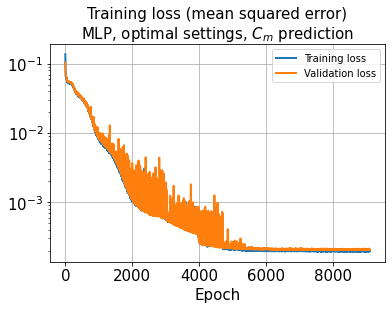

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

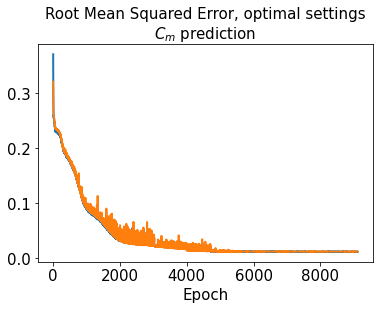

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

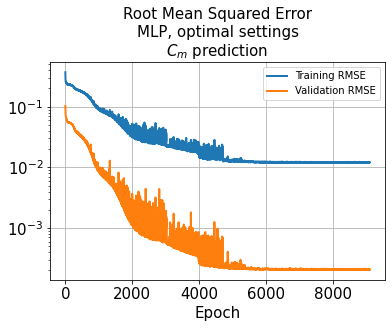

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

329/329 [==============================] - 1s 3ms/step - loss: 1.9707e-04 - rmse: 0.0121


In [35]:
val_results = model.evaluate(x_val, y_val)

94/94 [==============================] - 0s 3ms/step - loss: 2.0447e-04 - rmse: 0.0124


In [36]:
test_results = model.evaluate(x_test, y_test)

47/47 [==============================] - 0s 3ms/step - loss: 2.1309e-04 - rmse: 0.0127


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

47/47 [==============================] - 0s 1ms/step


In [38]:
decoded_train_

array([[0.300376  ],
       [0.2998553 ],
       [0.3029456 ],
       ...,
       [0.01530988],
       [0.25242618],
       [0.26395607]], dtype=float32)

In [39]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [40]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [41]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [44]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [45]:
model_directory = "D:\\TrainedModels\\20221227"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221227unsteadyValidation_MLP_012Flaps_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [47]:
os.chdir(storage_dir)

In [48]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [49]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.03593182793278749
2.201895180088961


In [50]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.036280831376162614
2.2465890692828565


In [51]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.03737175019279913
2.276928865735801


In [52]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [53]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [54]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [55]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [56]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [57]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [58]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

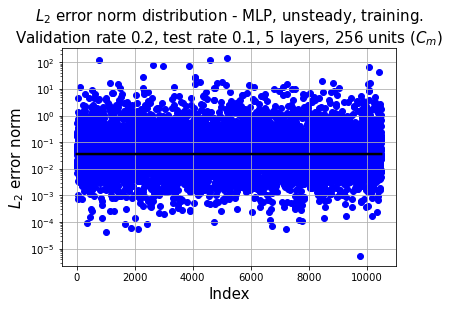

In [59]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

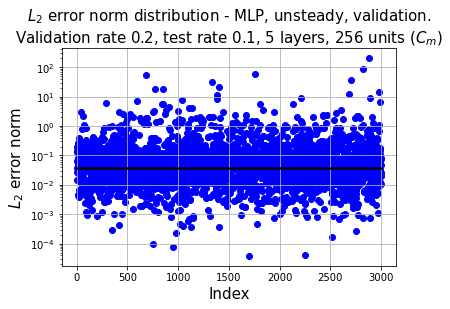

In [60]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

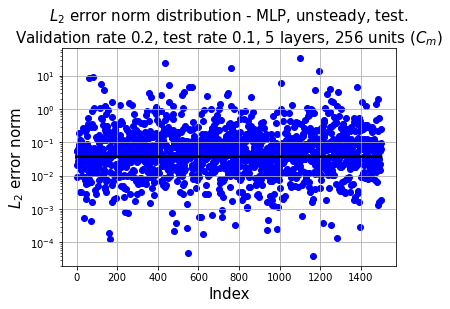

In [61]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [62]:
predicted = model.predict(x)

469/469 [==============================] - 1s 1ms/step


In [63]:
predicted.shape

(15000, 1)

In [64]:
l2_error(predicted, y)

0.02842676805244571

In [65]:
tTrain = x[index_train]+10
tVal = x[index_val]+10
tTest = x[index_test]+10

In [66]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [67]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [68]:
x += 10

In [69]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [70]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(1, 3):
    # Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
#     # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*(i-1):t_len*i,:]
    y_corres = y[t_len*(i-1):t_len*i,:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0296


NameError: name 'iTrain_' is not defined

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_train)
title_Cm = title_n_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
# plt.scatter(tVal, iVal, color='g', label='Validation set')
# plt.scatter(tTest,iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_val)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()